In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import timedelta
import scipy.stats as stats

## 데이터 전처리

### 3. 회원가입 완료(complete.signup)
- type : 로그인 방식

In [3]:
complete_signup = pd.read_csv('C:/Users/rmagm/OneDrive/바탕 화면/vscode/구독서비스프로덕트데이터/complete.signup.csv')

In [4]:
# 명확한 크롤링 데이터 제거
complete_signup_df =complete_signup.loc[complete_signup['os_name'] != 'Chrome Headless']

# reset_index
complete_signup_df =complete_signup_df.reset_index(drop=True)

# client_event_time 데이터 타입 변경
complete_signup_df['client_event_time'] = pd.to_datetime(complete_signup_df['client_event_time'])

# 9시간 추가 (KST 변환)
complete_signup_df["client_event_time"] = complete_signup_df["client_event_time"] + timedelta(hours=9)

#2022년 1월 ~ 2023년 12월
complete_signup_df = complete_signup_df[complete_signup_df['client_event_time'].dt.year.isin([2022,2023])]


In [5]:
# 타입 test행 제거
complete_signup_df = complete_signup_df[complete_signup_df['type'] != 'test']

In [6]:
# user_id 중복 제거
complete_signup_df = complete_signup_df.drop_duplicates(subset = ['user_id'], keep = False)

### 8. 첫 결제 완료(complete.subscription)

In [7]:
complete_subscription = pd.read_csv('C:/Users/rmagm/OneDrive/바탕 화면/vscode/구독서비스프로덕트데이터/complete.subscription.csv')

In [8]:
complete_subscription_df = complete_subscription[['city',	'client_event_time','event_type','os_name','user_id',
                                            'plan.price','paid_amount',	'coupon.discount_amount','pg.type']].rename(columns = {
                                                                                                                    'plan.price' : 'complete_sub_plan_price',
                                                                                                                    'paid_amount' : 'complete_sub_paid_amount',
                                                                                                                    'coupon.discount_amount' : 'complete_sub_coupon_discount_amount',
                                                                                                                    'pg.type' : 'pg_type',
                                                                                                                    'client_event_time' : 'complete_sub_time'})

# 크롤링 데이터 제거
complete_subscription_df =complete_subscription_df.loc[complete_subscription_df['os_name'] != 'Chrome Headless']

# reset_index
complete_subscription_df =complete_subscription_df.reset_index(drop=True)

# client_event_time 데이터 타입 변경
complete_subscription_df['complete_sub_time'] = pd.to_datetime(complete_subscription_df['complete_sub_time'])

# 9시간 추가 (KST 변환)
complete_subscription_df["complete_sub_time"] = complete_subscription_df["complete_sub_time"] + timedelta(hours=9)

#2022년 1월 ~ 2023년 12월
complete_subscription_df = complete_subscription_df[complete_subscription_df['complete_sub_time'].dt.year.isin([2022,2023])]

In [9]:
# 첫 결제가 중복인 경우 첫 결제 환불 후 다시 결제한 케이스로 보기 때문에 가장 최근 결제 내역만 남기기로 함
complete_subscription_df = complete_subscription_df.sort_values(by = 'complete_sub_time')

# user_id별 가장 최근 결제 내역 1건만 남기고 중복 제거
complete_subscription_df = complete_subscription_df.drop_duplicates(subset ='user_id', keep = 'last')

In [75]:
complete_subscription_df.shape

(13875, 9)

### 11. 서비스 무료체험 시작(start.free_trial)

- plan.price : 정상가
- plan.type : 요금제 종류
- trial.type : 무료체험 방식   

    - type A(구버전)    
            - 특정 컨텐츠 하나에 대해 영구적인 무료체험을 제공    
            - 여러 컨텐츠에 걸쳐서 중복 무료체험 제공하였음 -> (어떤 컨텐츠인지 정보는 남아있지 않음) 

    - type B (신버전)     
            - 기간 단위로 모든 컨텐츠를 경험할 수 있는 버전으로 제공    
            - 중복 무료체험 제공하지 않음

In [10]:
start_free_trial = pd.read_csv('C:/Users/rmagm/OneDrive/바탕 화면/vscode/구독서비스프로덕트데이터/start.free_trial.csv')
start_free_trial.head(3)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,plan.price,plan.type,trial.type
0,Seoul,2023-04-05 21:49:36.156000,South Korea,NaN,Mac,Mac,start.free_trial,Korean,Safari,15.6.1,Web,06b6868000a5d576180aca47896d6cce,15920.0,1개월 플랜,B
1,Dobong-gu,2023-03-12 08:28:29.384000,South Korea,NaN,Windows,Windows,start.free_trial,Korean,Chrome,110.0.0.0,Web,40acc1ddfc012f3d2f58a3de95e9e748,15920.0,1개월 플랜,B
2,NaN,2023-03-12 08:35:00.107000,NaN,NaN,NaN,NaN,start.free_trial,NaN,NaN,NaN,NaN,38aca03fba9753a6b2f31b829fb16a30,15920.0,1개월 플랜,B


In [11]:
start_free_trial_df = start_free_trial[['client_event_time','os_name','user_id',
                                            'plan.price','plan.type','trial.type']].rename(columns = {'plan.price' : 'start_free_trial_plan_price',
                                                                                                        'plan.type' : 'start_free_trial_plan_type',
                                                                                                        'trial.type' : 'start_free_trial_type',
                                                                                                        'client_event_time' : 'start_free_trial_time'})

# 사용하지 않는 device carrier 컬럼 제거
#start_free_trial_df.drop(columns='device_carrier',inplace=True)

# 명확한 크롤링 데이터
start_free_trial_df =start_free_trial_df.loc[start_free_trial_df['os_name'] != 'Chrome Headless']

# reset_index
start_free_trial_df =start_free_trial_df.reset_index(drop=True)

# client_event_time 데이터 타입 변경
start_free_trial_df['start_free_trial_time'] = pd.to_datetime(start_free_trial_df['start_free_trial_time'])

# 9시간 추가 (KST 변환)
start_free_trial_df["start_free_trial_time"] = start_free_trial_df["start_free_trial_time"] + timedelta(hours=9)

#2022년 1월 ~ 2023년 12월
start_free_trial_df = start_free_trial_df[start_free_trial_df['start_free_trial_time'].dt.year.isin([2022,2023])]

In [12]:
# user_id 결측 데이터 제거
start_free_trial_df = start_free_trial_df.dropna(subset=['user_id'])
start_free_trial_df.shape

# 중복 제거 전 A타입의 무료 체험과 B타입 무료 체험 모두 이용한 유저 추출

filtered_df = start_free_trial_df.groupby('user_id').filter(
    lambda group : ('A' in group['start_free_trial_type'].values) and  ('B' in group['start_free_trial_type'].values)
)
#사용할 컬럼만 추출
free_trial_df = start_free_trial_df[['user_id','start_free_trial_time','start_free_trial_type']]

# A와 B 모두 사용한 유저 목록 추출
users_to_remove = filtered_df["user_id"].unique()

# A와 B 모두 사용한 유저 제거 
free_trial_df = free_trial_df[~free_trial_df["user_id"].isin(users_to_remove)]
free_trial_df.shape

(30472, 3)

In [13]:
# start_free_trial_time 가장 첫 행(처음 무료 체험 서비스 시작 날짜)만 남기기
free_trial_df = free_trial_df.sort_values(by="start_free_trial_time", ascending=True).drop_duplicates(subset="user_id", keep="first")

# 결과 확인
free_trial_df.shape

(16268, 3)

## 주제 선정 후 분석 진행

- 루팡 유저 판별 기준(무료 체험 서비스 이용만 하고 사라진 유저)
    1. 무료 체험 서비스 이용은 했지만 정기 구독을 하지 않은 유저(무료 체험 서비스 이용 기록만 존재)

- 루팡 유저들의 결제 페이지 진입 기록 
    - 결제 페이지에 진입했다면 진입까지 걸린 평균 시간
- 루팡 유저들의 메인 페이지 진입 수
- 루팡 유저들의 유입 경로 비교 -> 마케팅 전략 제안 가능 -> 시각화 가능
- 무료 체험 서비스를 이용한 루팡들이 어느 레슨과 컨텐츠를 사용했는지
- 13.enter.lesson_page 데이터에 is_trial 컬럼이 무료 체험했으나 현재 구독하지 않은 회원인지의 여부를 알려주고 있어요. 이 부분도 더블 체크 해보시는게 좋을 것 같아요! 무료체험 서비스 데이터가 아무래도 4월 30일까지여서,
- type b는 제 기억엔 모두 정기 결제를 한게 맞구(확인을 그래도 한 번 하는게 좋아옄ㅋㅋ)  7일 무료 체험하고 취소한 걸 따로 봐야겠네여(merge…)
- 무료 체험 서비스 a,b type 따로 봐야 할 것 같아요(a는 2023년, b는 2024년)

- PQL(제품을 무료로 사용해 본 후, 유료 전환 가능성이 높은 잠재 고객을 의미)
- TYPE B의 경우 7일의 무료체험 기간이 끝나고 이후에 결제로 넘어가기 때문에 첫 결제 내역이 남아있지 않음 -> 무료 체험 기간이 끝나기 전에 정기결제 취소했기 때문에 루팡

In [14]:
palette = ['#b3cde0', '#7e79b8', '#eac4d5', '#6e58a7', '#c6e2e9',
            '#a9a7cf', '#9dc3c1','#d5d5e9', '#baaad0', '#f8c8dc', '#c5b9f2']  

sns.set_palette(palette)

In [15]:
A_start = start_free_trial_df[start_free_trial_df['start_free_trial_type'] == 'A']['start_free_trial_time'].min()
A_end = start_free_trial_df[start_free_trial_df['start_free_trial_type'] == 'A']['start_free_trial_time'].max()

B_start = start_free_trial_df[start_free_trial_df['start_free_trial_type'] == 'B']['start_free_trial_time'].min()
B_end = start_free_trial_df[start_free_trial_df['start_free_trial_type'] == 'B']['start_free_trial_time'].max()

In [16]:
# 1. 회원가입 후 무료 체험 서비스을 경험해본 유저 추출

# 무료 체험 기간 회원가입 완료
complete_signup_df2 = complete_signup_df[['user_id','client_event_time']]
complete_signup_df_count = complete_signup_df['user_id'].nunique()

# 무료 체험 서비스 기간에 회원 가입한 유저 필터링

complete_signup_df3 = complete_signup_df2[
    (
        ((complete_signup_df2["client_event_time"] >= A_start) & (complete_signup_df2["client_event_time"] <= A_end)) | 
        ((complete_signup_df2["client_event_time"] >= B_start) & (complete_signup_df2["client_event_time"] <= B_end))
    )
]
signup_user = complete_signup_df3['user_id'].nunique()

#  회원 가입 서비스 무료 체험 이용 유저 merge
complete_signup_trial = free_trial_df.merge(complete_signup_df3, how  = 'inner', on = 'user_id')

# 전체 회원가입 유저 수 및 회원가입 후 무료체험 이용 유저 수 계산
total_signup = complete_signup_df3["user_id"].nunique()  # 전체 회원가입 유저 수
total_trial_users = complete_signup_trial["user_id"].nunique()  # 회원가입 후 무료체험을 이용한 유저 수

# 비율 계산
trial_users_ratio = (total_trial_users / total_signup) * 100

# 결과
print("전체 기간(22,23) 회원 가입 유저 수 :" ,  complete_signup_df_count)
print("무료 체험 기간 회원 가입한 유저 수 :", signup_user)
print('-' * 70)
print("<무료 체험 서비스 기간 기준>")
print("회원가입 후 무료 체험 서비스를 이용한 유저 수:", total_trial_users)
print(f"회원가입 후 무료 체험 서비스를 이용한 유저 비율(%): {trial_users_ratio:.2f}%")


전체 기간(22,23) 회원 가입 유저 수 : 145081
무료 체험 기간 회원 가입한 유저 수 : 67740
----------------------------------------------------------------------
<무료 체험 서비스 기간 기준>
회원가입 후 무료 체험 서비스를 이용한 유저 수: 14095
회원가입 후 무료 체험 서비스를 이용한 유저 비율(%): 20.81%


In [17]:
# 무료 체험 서비스 여러 번 한 유저인 경우 가장 최근 이용 내역만 남기기로 함
complete_signup_trial = complete_signup_trial.sort_values(by = 'start_free_trial_time')
# signup_free_trial
# user_id별 가장 최근 결제 내역 1건만 남기고 중복 제거
complete_signup_trial = complete_signup_trial.drop_duplicates(subset ='user_id', keep = 'first')
complete_signup_trial.head()

,user_id,start_free_trial_time,start_free_trial_type,client_event_time
0,28562e887d0942c8f422f1ffa1c12bc0,2022-01-01 09:30:35.744,A,2022-01-01 09:29:36.534
1,346239bb0b26fb4b4314b08e884b7e15,2022-01-01 11:11:57.529,A,2022-01-01 11:09:29.914
2,1535248f825028bae04dc0eee26d43ef,2022-01-01 11:25:07.253,A,2022-01-01 11:22:00.036
3,cf226fb4193276063956cefeed0de36d,2022-01-01 12:52:05.313,A,2022-01-01 12:39:16.766
4,f9c0191db74185ee5af63920c37c9499,2022-01-01 13:09:16.943,A,2022-01-01 13:08:23.891


In [18]:
# A/B 타입별 무료 체험을 이용한 유저 필터링
signup_free_trial_A = complete_signup_trial[complete_signup_trial["start_free_trial_type"] == "A"]
signup_free_trial_B = complete_signup_trial[complete_signup_trial["start_free_trial_type"] == "B"]


# A/B 타입별 무료 체험 이용 유저 수
total_trial_users_A = signup_free_trial_A["user_id"].nunique()
total_trial_users_B = signup_free_trial_B["user_id"].nunique()

# A/B 타입별 무료 체험 이용 비율
trial_users_ratio_A = (total_trial_users_A / total_trial_users) * 100
trial_users_ratio_B = (total_trial_users_B / total_trial_users) * 100

# 결과 출력
print(f"무료 체험 서비스 이용 기간 회원가입 후 무료 체험 이용 유저 수: {total_trial_users}")
print(f"TYPE A 기간 - 무료 체험 이용 유저 수: {total_trial_users_A}")
print(f"TYPE B 기간 - 무료 체험 이용 유저 수: {total_trial_users_B}")


무료 체험 서비스 이용 기간 회원가입 후 무료 체험 이용 유저 수: 14095
TYPE A 기간 - 무료 체험 이용 유저 수: 11992
TYPE B 기간 - 무료 체험 이용 유저 수: 2103


C:\Users\rmagm\AppData\Local\Temp\ipykernel_7984\2832654244.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=trial_users_df, x="Type", y="Number of Users", palette= palette)
C:\Users\rmagm\AppData\Local\Temp\ipykernel_7984\2832654244.py:12: UserWarning: The palette list has more values (11) than needed (2), which may not be intended.
  ax = sns.barplot(data=trial_users_df, x="Type", y="Number of Users", palette= palette)


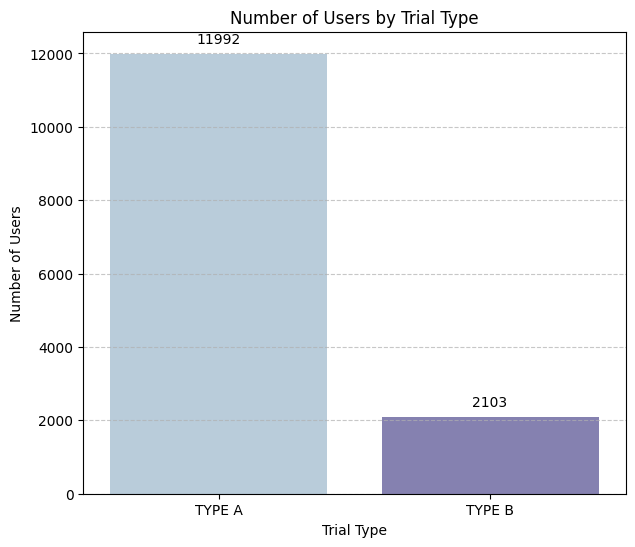

In [19]:
# 데이터 준비
trial_users_data = {
    "Type": ["TYPE A", "TYPE B"],
    "Number of Users": [total_trial_users_A, total_trial_users_B]
}

# DataFrame 생성
trial_users_df = pd.DataFrame(trial_users_data)

# 시각화
plt.figure(figsize=(7, 6))
ax = sns.barplot(data=trial_users_df, x="Type", y="Number of Users", palette= palette)

# 막대 위에 값 표시
for container in ax.containers:
    ax.bar_label(container, fmt="%d", label_type="edge", fontsize=10, padding=5)

# 그래프 설정
plt.xlabel("Trial Type")
plt.ylabel("Number of Users")
plt.title("Number of Users by Trial Type")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [20]:
# 2. 회원 가입 완료 회원의 무료 서비스 체험 후 첫 결제 완료(무료 서비스 체험 사용 기간 내)

# 2-1. 중복 결제 내역 제거한 첫 결제 완료 데이터에서 필요한 컬럼만 추출
complete_subscription_final = complete_subscription_df[
    ['user_id', 'complete_sub_time']
]

# 2-2. 무료 체험 유저와 첫 결제 완료 데이터 merge
free_trial_complete = complete_signup_trial.merge(complete_subscription_final, on='user_id', how='left')

# 2-3. 무료 체험 후 첫 결제를 완료한 유저 필터링

#(조건 : start_free_trial_time < complete_subscription_time) : row = 3147 -> 구독전환율
# 무료 체험 서비스 이용 시간이 먼저여야 하는 이유는 만약 첫 결제 완료 후에 무료 체험 레슨을 들었을 변수를 제외시키기 위해서

free_trial_complete_yes = free_trial_complete[
    free_trial_complete['start_free_trial_time'].notna() &  # 무료 체험 시작 시간이 존재하는 경우
    (free_trial_complete['start_free_trial_time'] < free_trial_complete['complete_sub_time']) 
]

# 2-4. 무료 체험 후 첫 결제 완료한 유저 수 및 전환율 계산
free_trial_complete_yes_users = free_trial_complete_yes['user_id'].nunique()
total_trial_users = complete_signup_trial['user_id'].nunique()  # 무료 체험 체험 기간동안 회원가입 후 무료 체험 전체 유저 수

free_trial_complete_yes_rate = (free_trial_complete_yes_users / total_trial_users) * 100

print(f'무료 체험 서비스 이용 후 첫 결제 완료 유저 수 : {free_trial_complete_yes_users}')
print(f'무료 체험 서비스 이용 후 첫 결제 완료 유저 비율 : {free_trial_complete_yes_rate:.2f}%')

free_trial_complete_yes


무료 체험 서비스 이용 후 첫 결제 완료 유저 수 : 3042
무료 체험 서비스 이용 후 첫 결제 완료 유저 비율 : 21.58%


,user_id,start_free_trial_time,start_free_trial_type,client_event_time,complete_sub_time
0,28562e887d0942c8f422f1ffa1c12bc0,2022-01-01 09:30:35.744,A,2022-01-01 09:29:36.534,2022-12-20 12:07:22.599
15,50d0dd8cc013bda776654d037afde6c2,2022-01-01 19:15:55.519,A,2022-01-01 19:15:16.345,2022-02-24 18:18:54.709
24,92cf46463225e0912034afda9baabbc5,2022-01-01 21:17:48.140,A,2022-01-01 21:16:19.261,2022-11-15 21:30:59.109
49,3aa4a3f14c8a2b15035f34d9c2af8d3d,2022-01-02 15:40:13.801,A,2022-01-02 15:38:31.202,2022-07-09 22:13:54.750
56,10c43b95e86fd0feb871bd21bede50c6,2022-01-02 16:58:18.424,A,2022-01-02 16:38:03.080,2022-03-03 19:36:38.442
...,...,...,...,...,...
14087,380c802d65358647590d3eb726c0ba35,2023-04-30 20:13:26.312,B,2023-04-26 19:51:13.388,2023-05-07 20:15:01.872
14088,31a3ef22ef5bb71492530b6790c296da,2023-04-30 20:22:15.209,B,2023-04-30 16:49:32.485,2023-05-07 20:25:02.196
14091,7079785832f489a60be4583d4858a88d,2023-04-30 22:13:44.708,B,2023-04-30 20:20:32.282,2023-12-31 20:17:51.820
14092,15db6de4ab4dd0c20f1c4dd377e6aaa3,2023-04-30 22:56:07.995,B,2023-03-20 22:56:44.193,2023-05-07 23:00:01.670


In [21]:
# Calculate number of users who completed first payment after free trial for each type
free_trial_complete_yes_type = free_trial_complete_yes.groupby("start_free_trial_type")["user_id"].nunique().reset_index()
free_trial_complete_yes_type.columns = ["Trial Type", "Number of Users"]

# Calculate total trial users for each type
total_trial_users_A = complete_signup_trial[complete_signup_trial["start_free_trial_type"] == "A"]["user_id"].nunique()
total_trial_users_B = complete_signup_trial[complete_signup_trial["start_free_trial_type"] == "B"]["user_id"].nunique()

# Calculate conversion rate for each type
free_trial_complete_yes_rate_A = (free_trial_complete_yes_type.loc[free_trial_complete_yes_type["Trial Type"] == "A", "Number of Users"].values[0] / total_trial_users_A) * 100
free_trial_complete_yes_rate_B = (free_trial_complete_yes_type.loc[free_trial_complete_yes_type["Trial Type"] == "B", "Number of Users"].values[0] / total_trial_users_B) * 100

# Print results
print(f'TYPE A - 무료 체험 서비스 이용 후 첫 결제 완료 유저 수: {free_trial_complete_yes_type.loc[free_trial_complete_yes_type["Trial Type"] == "A", "Number of Users"].values[0]}')
print(f'TYPE A - 무료 체험 서비스 이용 후 첫 결제 완료 유저 비율: {free_trial_complete_yes_rate_A:.2f}%')

print(f'TYPE B - 무료 체험 서비스 이용 후 첫 결제 완료 유저 수: {free_trial_complete_yes_type.loc[free_trial_complete_yes_type["Trial Type"] == "B", "Number of Users"].values[0]}')
print(f'TYPE B - 무료 체험 서비스 이용 후 첫 결제 완료 유저 비율: {free_trial_complete_yes_rate_B:.2f}%')


TYPE A - 무료 체험 서비스 이용 후 첫 결제 완료 유저 수: 2174
TYPE A - 무료 체험 서비스 이용 후 첫 결제 완료 유저 비율: 18.13%
TYPE B - 무료 체험 서비스 이용 후 첫 결제 완료 유저 수: 868
TYPE B - 무료 체험 서비스 이용 후 첫 결제 완료 유저 비율: 41.27%


,Trial Type,Number of Users
0,A,2174
1,B,868


C:\Users\rmagm\AppData\Local\Temp\ipykernel_7984\3099973154.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=free_trial_complete_yes_type, x="Trial Type", y="Number of Users", palette= palette)
C:\Users\rmagm\AppData\Local\Temp\ipykernel_7984\3099973154.py:11: UserWarning: The palette list has more values (11) than needed (2), which may not be intended.
  ax = sns.barplot(data=free_trial_complete_yes_type, x="Trial Type", y="Number of Users", palette= palette)


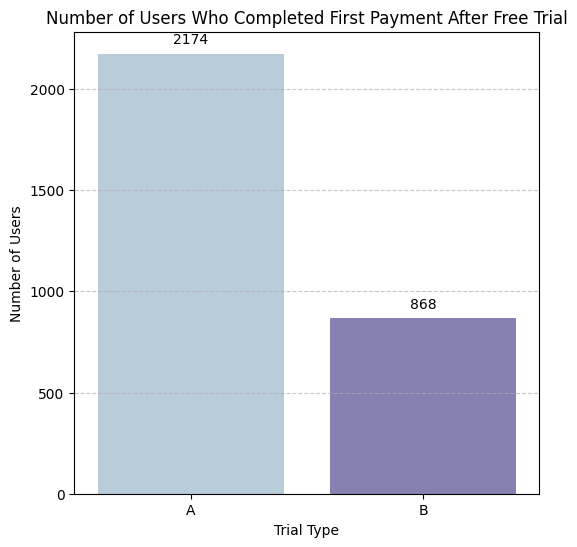

In [22]:
# 타입별 무료 체험 후 첫 결제 완료 유저 수 계산
free_trial_complete_yes_type = free_trial_complete_yes.groupby("start_free_trial_type")["user_id"].nunique().reset_index()

# 컬럼명 변경
free_trial_complete_yes_type.columns = ["Trial Type", "Number of Users"]

# 결과
display(free_trial_complete_yes_type)

plt.figure(figsize=(6, 6))
ax = sns.barplot(data=free_trial_complete_yes_type, x="Trial Type", y="Number of Users", palette= palette)

# 바 그래프 수치 추가
for container in ax.containers:
    ax.bar_label(container, fmt="%d", label_type="edge", fontsize=10, padding=5)

plt.xlabel("Trial Type")
plt.ylabel("Number of Users")
plt.title("Number of Users Who Completed First Payment After Free Trial")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


###  TYPE 별 무료 서비스 체험 후 첫 결제까지 걸린 평균 결제 시간 

In [23]:
# 무료 체험 후 첫 결제 까지 걸린 시간(일 단위)
free_complete_yes = free_trial_complete_yes.copy()

free_complete_yes['day_to_conversion'] = (free_complete_yes['complete_sub_time'] - free_complete_yes['start_free_trial_time']).dt.total_seconds() / 86400

# 전체 평균 및 첫 결제까지 소요 시간 
free_complete_yes_avg = free_complete_yes['day_to_conversion'].mean()

# TYPE A와 TYPE B 소요 시간 평균 계산
free_complete_yes_type_avg = free_complete_yes.groupby('start_free_trial_type')['day_to_conversion'].mean()

free_complete_yes_type_avg_df = free_complete_yes_type_avg.reset_index()
free_complete_yes_type_avg_df.columns = ["Trial Type", "Avg Conversion Days"]

print(f"전체 평균 첫 결제 소요 시간: {free_complete_yes_avg:.2f}일")
print("\nType A와 Type B별 평균 첫 결제 소요 시간:")
print(free_complete_yes_type_avg_df.to_string(index=False, float_format="%.2f"))

전체 평균 첫 결제 소요 시간: 24.36일

Type A와 Type B별 평균 첫 결제 소요 시간:
Trial Type  Avg Conversion Days
         A                28.42
         B                14.21


C:\Users\rmagm\AppData\Local\Temp\ipykernel_7984\4216840546.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=free_complete_yes_type_avg_df, x="Trial Type", y="Avg Conversion Days", palette="Blues")


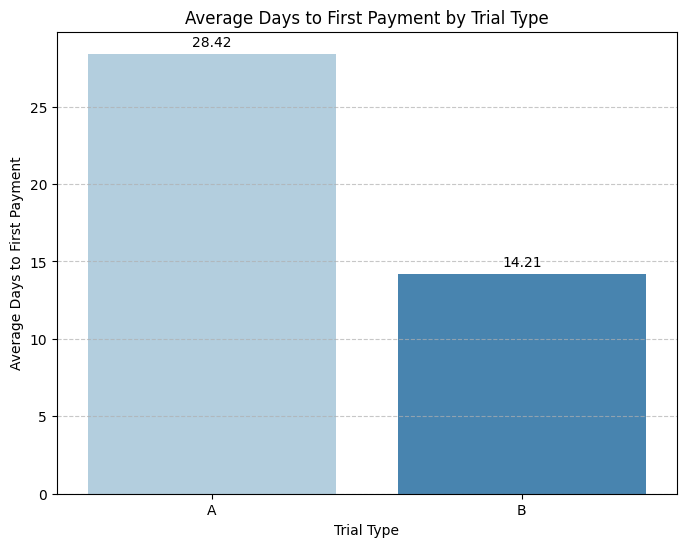

In [24]:
plt.figure(figsize=(8, 6))

# 바 그래프
ax = sns.barplot(data=free_complete_yes_type_avg_df, x="Trial Type", y="Avg Conversion Days", palette="Blues")

# 바 위에 수치 추가
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=10, padding=3)

plt.xlabel("Trial Type")
plt.ylabel("Average Days to First Payment")
plt.title("Average Days to First Payment by Trial Type")
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.show()

In [25]:
# Type A 첫 결제까지 가장 빠른 유저 TOP 5
print("=" * 60)  
print("\n Type A - 첫 결제까지 가장 빠른 유저 TOP 5")
print(free_complete_yes[free_complete_yes["start_free_trial_type"] == "A"]
      .nsmallest(5, "day_to_conversion")[["user_id", "day_to_conversion"]]
      .to_string(index=False, float_format="%.2f"))

# Type A 첫 결제까지 가장 오래 걸린 유저 TOP 5
print("=" * 60)  
print("\n Type A - 첫 결제까지 가장 오래 걸린 유저 TOP 5")
print(free_complete_yes[free_complete_yes["start_free_trial_type"] == "A"]
      .nlargest(5, "day_to_conversion")[["user_id", "day_to_conversion"]]
      .to_string(index=False, float_format="%.2f"))
print("=" * 60)


 Type A - 첫 결제까지 가장 빠른 유저 TOP 5
                         user_id  day_to_conversion
f046f930dec0224ebb91e499204b2e46               0.00
33aa47ab1eec81d4e2ede2675760f23c               0.00
6d10fbd72d86df1c890bb5904bcd2a17               0.00
fd888a8f9fed0a7ea033b38d4bb81357               0.00
9bfbac2af69231accf068239519e0f2f               0.00

 Type A - 첫 결제까지 가장 오래 걸린 유저 TOP 5
                         user_id  day_to_conversion
783e01211e03edc828d55baf6e08a256             711.14
fa58177660c687803ee14ac44f3d5cae             662.17
7f51e642d2a5d1b2586cf4343b7a54d2             614.68
f6657eeff454e7ebe4570bc5f174bb1b             587.22
8664c2eb847f36c445caf1784bd9ae2e             564.94


In [26]:

# Type B 첫 결제까지 가장 빠른 유저 TOP 5
print("=" * 60) 
print("\n Type B - 첫 결제까지 가장 빠른 유저 TOP 5")
print(free_complete_yes[free_complete_yes["start_free_trial_type"] == "B"]
      .nsmallest(5, "day_to_conversion")[["user_id", "day_to_conversion"]]
      .to_string(index=False, float_format="%.2f"))

# Type B 첫 결제까지 가장 오래 걸린 유저 TOP 5
print("=" * 60)  
print("\n Type B - 첫 결제까지 가장 오래 걸린 유저 TOP 5")
print(free_complete_yes[free_complete_yes["start_free_trial_type"] == "B"]
      .nlargest(5, "day_to_conversion")[["user_id", "day_to_conversion"]]
      .to_string(index=False, float_format="%.2f"))
print("=" * 60) 


 Type B - 첫 결제까지 가장 빠른 유저 TOP 5
                         user_id  day_to_conversion
9611d4cacc12eca45b2c56e76d99a447               0.00
3e0f99f28e28196e4a267d19c335f444               0.00
6125c2ddf601a13532204ccd2f6e587d               0.01
5288c36731e73a1941699d37f3a69a27               0.01
3c701c93fb7895d4316698c1bc6117c4               0.01

 Type B - 첫 결제까지 가장 오래 걸린 유저 TOP 5
                         user_id  day_to_conversion
d162f934feab36bd13e9da679fd3e4ad             296.70
433cc7db3d9f741cf9a1108d8f78e777             269.82
6c65d646cdbb1bea21fcbc37173404f4             258.61
7079785832f489a60be4583d4858a88d             244.92
2a5784ad88b5e6ca7d692da3c39f597d             232.89


C:\Users\rmagm\AppData\Local\Temp\ipykernel_7984\3747629084.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=free_complete_yes["start_free_trial_type"], y=free_complete_yes["day_to_conversion"], palette = palette)
C:\Users\rmagm\AppData\Local\Temp\ipykernel_7984\3747629084.py:1: UserWarning: The palette list has more values (11) than needed (2), which may not be intended.
  sns.boxplot(x=free_complete_yes["start_free_trial_type"], y=free_complete_yes["day_to_conversion"], palette = palette)


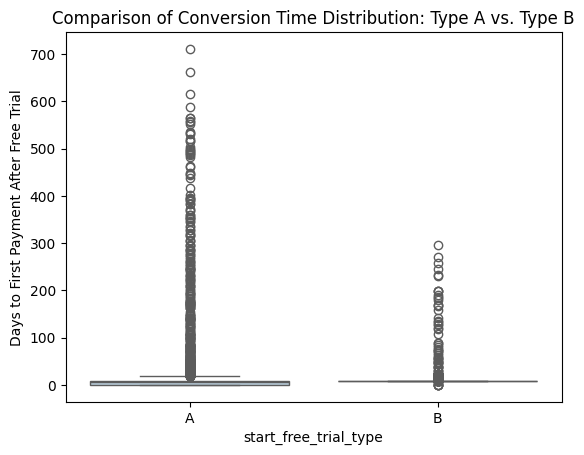

In [27]:
sns.boxplot(x=free_complete_yes["start_free_trial_type"], y=free_complete_yes["day_to_conversion"], palette = palette)
plt.ylabel("Days to First Payment After Free Trial")
plt.title("Comparison of Conversion Time Distribution: Type A vs. Type B") # 결제 소요 시간 비교
plt.show()

### 박스플롯 설명

- 여기서 이상치는 무료 체험 서비스의 영향을 받는 기간을 지나 첫 결제를 진행한 유저들을 칭함

1. TYPE A    

- Type A는 전환 시간이 훨씬 길고 이상치가 많음    

- Type A는 700일 가까이 걸린 유저도 존재 → 일부 유저는 무료 체험 후 매우 오랜 시간이 지난 후 결제(무료 체험이 첫 결제에 미치는 영향이 극히 적을 것으로 예상 할 수 있음)    

- 박스가 매우 짧고 위쪽으로 이상치가 많음 → 대부분의 유저는 빠르게 전환하지만, 일부는 매우 늦게 결제    

2. TYPE B    
- Type B는 상대적으로 빠르게 전환됨     

- Type B는 최대 300일 정도 이상치가 존재하지만, Type A보다 확연히 적음       
 
- 박스가 더 길고 이상치 분포가 상대적으로 적음 → Type B는 좀 더 균일한 전환 패턴을 보임(그래도 장시간 이후에 첫 결제라면 무료 체험의 영향력은 작다고 판단)


### 무료 서비스 체험의 영향으로 첫 결제까지 이어진 유저 재지정

- TYPE A (영구 무료 체험)    

    - 무료 체험이 영구적이기 때문에, 사용자는 즉시 결제할 필요가 없음.    

    - 하지만 무료 체험 서비스가 일정 기간 동안 영향을 주어 결제로 이어지는 시점이 존재할 가능성이 있음.    

    - 무료 체험의 "잔존 효과" 반영    
        - 무료 체험이 끝나지 않더라도, 무료 체험의 영향으로 일정 기간 내 결제를 유도할 가능성이 있음.

In [28]:
# 특정 기간 내 첫 결제한 유저 수를 계산하는 함수 (누적 아님)
def count_conversions_in_period(conversion_data, start_day, end_day=None):
    """
    특정 시작일과 종료일 사이에 첫 결제를 완료한 유저 수를 계산하는 함수.
    - end_day가 None이면 start_day 이후(first conversion > start_day) 모든 유저를 포함
    """
    if end_day is None:  # 90일 이후 유저 수 계산
        return (conversion_data > start_day).sum()
    return ((conversion_data > start_day) & (conversion_data <= end_day)).sum()

# 전환율 분석 기간 설정 (7일, 15일, 30일, 60일, 90일, 90일 이후)
conversion_periods = [(0, 7), (7, 15), (15, 30), (30, 60), (60, 90), (90, None)] 

# TYPE A와 TYPE B 유저 데이터 분리
type_A_conversion = free_complete_yes[free_complete_yes["start_free_trial_type"] == "A"]["day_to_conversion"]
type_B_conversion = free_complete_yes[free_complete_yes["start_free_trial_type"] == "B"]["day_to_conversion"]

# 각 기간별 첫 결제 유저 수 계산
conversion_counts_A = {f"{start} - {end} days" if end else f"{start} + days": count_conversions_in_period(type_A_conversion, start, end) 
                       for start, end in conversion_periods}

conversion_counts_B = {f"{start} - {end} days" if end else f"{start} + days": count_conversions_in_period(type_B_conversion, start, end) 
                       for start, end in conversion_periods}

# 데이터프레임 생성
conversion_df = pd.DataFrame({
    "무료 체험 시작 후 첫 결제까지 소요 시간": list(conversion_counts_A.keys()),
    "TYPE A ": list(conversion_counts_A.values()),
    "TYPE B ": list(conversion_counts_B.values())
})

conversion_df

,무료 체험 시작 후 첫 결제까지 소요 시간,TYPE A,TYPE B
0,0 - 7 days,1165,5
1,7 - 15 days,614,781
2,15 - 30 days,105,32
3,30 - 60 days,81,15
4,60 - 90 days,35,10
5,90 + days,174,25


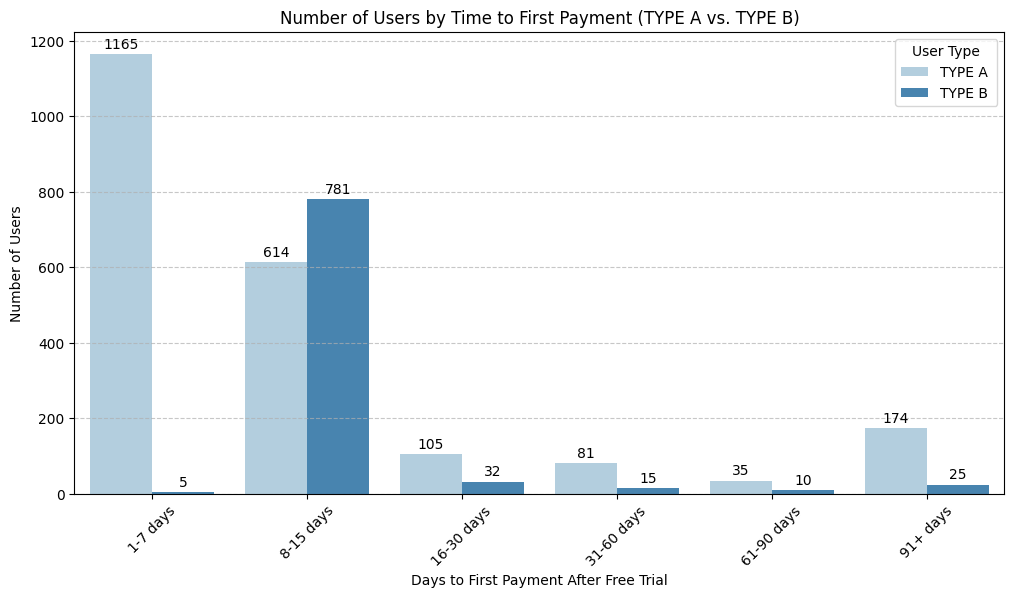

In [29]:
# 각 타입별 무료 체험 시작 후 첫 결제까지 소요 시간별 유저 수"

# Rename columns for visualization
conversion_df.rename(columns={
    "무료 체험 시작 후 첫 결제까지 소요 시간": "Days to First Payment",
    "TYPE A 30일 이내 첫 결제 유저 수": "TYPE A Conversions",
    "TYPE B 30일 이내 첫 결제 유저 수": "TYPE B Conversions"
}, inplace=True)

# Convert DataFrame to long format for seaborn
conversion_melted_df = conversion_df.melt(id_vars=["Days to First Payment"],
                                          var_name="User Type", value_name="Number of Users")

# 시각화

new_labels = ["1-7 days", "8-15 days", "16-30 days", "31-60 days", "61-90 days", "91+ days"]

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=conversion_melted_df, x="Days to First Payment",
            y="Number of Users", hue="User Type", palette="Blues")

for container in ax.containers:
    ax.bar_label(container, fmt="%d", label_type="edge", fontsize=10, padding=2)


plt.xlabel("Days to First Payment After Free Trial")
plt.ylabel("Number of Users")
plt.title("Number of Users by Time to First Payment (TYPE A vs. TYPE B)")
plt.xticks(ticks=range(len(new_labels)), labels=new_labels, rotation=45)
plt.legend(title="User Type")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


- TYPE A

In [30]:
# TYPE A를 이용한 유저

# 60일 기준으로 결제 소요 시간 필터링 (Type A만)
threshold_A = 60

# Type A에서 60일 이하 유저 데이터 (빠르게 결제한 유저)
free_complete_yes_60_A = free_complete_yes[
    (free_complete_yes["start_free_trial_type"] == "A") & 
    (free_complete_yes["day_to_conversion"] <= threshold_A)
]

# Type A에서 60일 초과 유저 데이터 (늦게 결제한 유저)
free_complete_yes_above_60_A = free_complete_yes[
    (free_complete_yes["start_free_trial_type"] == "A") & 
    (free_complete_yes["day_to_conversion"] > threshold_A)
]

# 유저 수 계산
num_conversion_users_60_A = free_complete_yes_60_A["user_id"].nunique()
num_conversion_users_above_60_A = free_complete_yes_above_60_A["user_id"].nunique()

# 결과 출력
print(f"Type A - 60일 이내 유저 수: {num_conversion_users_60_A}명")
print(f"Type A - 60일 이후 유저 수: {num_conversion_users_above_60_A}명")

Type A - 60일 이내 유저 수: 1965명
Type A - 60일 이후 유저 수: 209명


In [31]:
# TYPE A의 60일 이내 유저 결제 시간 기초 통계량(무료 체험 후 60일 이내 첫 결제)
print('TYPE A 결제까지 60일 이내 결제 시간 기초 통계')
print(free_complete_yes_60_A["day_to_conversion"].describe())
print('-' * 60)
# TYPE A의 60일 이후 유저 결제 시간 기초 통계량(무료 체험 후 60일 초과 첫 결제)
print('TYPE A 결제까지 60일 이후 결제 시간 기초 통계')
print(free_complete_yes_above_60_A["day_to_conversion"].describe())

TYPE A 결제까지 60일 이내 결제 시간 기초 통계
count    1965.000000
mean        6.278166
std         9.539283
min         0.000621
25%         0.083870
50%         3.477258
75%         7.008394
max        59.873704
Name: day_to_conversion, dtype: float64
------------------------------------------------------------
TYPE A 결제까지 60일 이후 결제 시간 기초 통계
count    209.000000
mean     236.559651
std      150.625363
min       60.109954
25%      108.193962
50%      192.876575
75%      327.778624
max      711.135931
Name: day_to_conversion, dtype: float64


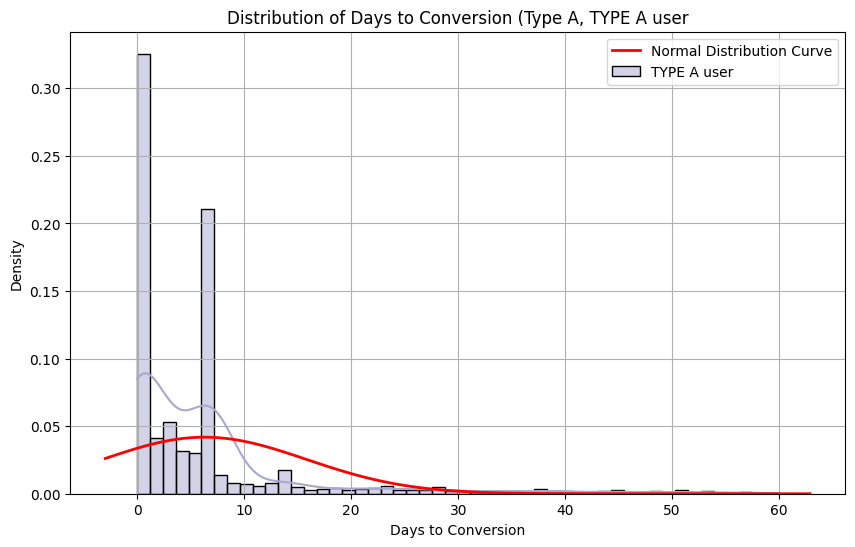

In [32]:
# 60일 이내 첫 결제 소요 시간 데이터 추출
type_A_conversion_days_60 = free_complete_yes_60_A["day_to_conversion"]

# 히스토그램 & KDE 시각화
plt.figure(figsize=(10, 6))
sns.histplot(type_A_conversion_days_60, bins=50, kde=True, color=palette[5], stat="density", label="TYPE A user") # a타입

# 정규 분포 곡선 추가
mu_90, std_90 = np.mean(type_A_conversion_days_60), np.std(type_A_conversion_days_60)
xmin, xmax = plt.xlim()  # x축 범위 설정
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu_90, std_90)
plt.plot(x, p, 'r', linewidth=2, label="Normal Distribution Curve") # label = "정규분포곡선"

# 그래프 설정
plt.xlabel("Days to Conversion")
plt.ylabel("Density")
plt.title("Distribution of Days to Conversion (Type A, TYPE A user")
plt.legend()
plt.grid()

# 그래프 출력
plt.show()

< 60일 이내 결제 시간 유저들>
- 무료 체험 후 60일 이내 유저가 실제 영향을 받은 그룹
- 평균 6일만에 결제 -> 무료 체험이 유저들에게 첫 결제로 이어지게 하는데 효과가 있었다.
- 표준 편차(약9일) 유저가 평균(6.04일)을 기준으로 ± 9일 범위 안에 많은 유저가 존재한다는 것 -> 전환율 분석 가능
- 즉 무료 체험 후 대부분이 유저가 6 ± 9일(즉, 0일~15일 사이)에 결제한 것을 알 수 있음
- 표준편차가 상대적으로 크지 않으며, 분포 또한 급격히 퍼져 있지 않음
- Q3가 7.00일로 유저가 7일 이내 결제했다는 것 -> 표준편차와 잘 맞아 떨어짐

-------------------------------------------------------------------------------------------------------------------------
- TYPE B

In [33]:
# TYPE B를 이용한 유저

# 60일 기준으로 결제 소요 시간 필터링 (Type B만)
threshold_B = 60

# Type A에서 60일 이내 유저 데이터 (빠르게 결제한 유저)
free_complete_yes_60_B = free_complete_yes[
    (free_complete_yes["start_free_trial_type"] == "B") & 
    (free_complete_yes["day_to_conversion"] <= threshold_B)
]

# Type A에서 60일 이후 유저 데이터 (늦게 결제한 유저)
free_complete_yes_above_60_B = free_complete_yes[
    (free_complete_yes["start_free_trial_type"] == "B") & 
    (free_complete_yes["day_to_conversion"] > threshold_B)
]

# 유저 수 계산
num_conversion_users_30_B = free_complete_yes_60_B["user_id"].nunique()
num_conversion_users_above_30_B = free_complete_yes_above_60_B["user_id"].nunique()

# 결과 출력
print(f"Type B - 60일 이내 결제 유저 수: {num_conversion_users_30_B}명")
print(f"Type B - 60일 이후 결제 유저 수: {num_conversion_users_above_30_B}명")

Type B - 60일 이내 결제 유저 수: 833명
Type B - 60일 이후 결제 유저 수: 35명


In [34]:
# TYPE B의 60일 이내 결제 유저 시간 기초 통계량(무료 체험 후 60일 이내 첫 결제)
print('TYPE B 결제까지 60일 이내 결제 시간 기초 통계')
print(free_complete_yes_60_B["day_to_conversion"].describe())
print('-' * 60)
# TYPE B의 30일 이내 결제 유저 시간 기초 통계량(무료 체험 후 60일 초과 첫 결제)
print('TYPE B 결제까지 60일 이후 결제 시간 기초 통계')
print(free_complete_yes_above_60_B["day_to_conversion"].describe())

TYPE B 결제까지 60일 이내 결제 시간 기초 통계
count    833.000000
mean       8.437338
std        6.075141
min        0.003013
25%        7.001066
50%        7.002097
75%        7.003108
max       59.450705
Name: day_to_conversion, dtype: float64
------------------------------------------------------------
TYPE B 결제까지 60일 이후 결제 시간 기초 통계
count     35.000000
mean     151.531001
std       64.871076
min       62.337262
25%       88.885866
50%      141.091300
75%      193.643672
max      296.702592
Name: day_to_conversion, dtype: float64


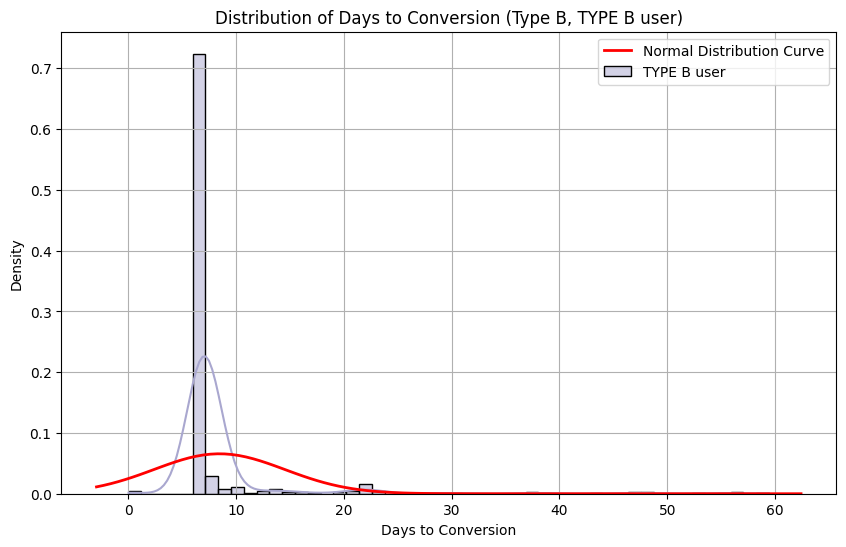

In [35]:
# 60일 기준으로 결제 소요 시간 데이터 추출
type_B_conversion_days_60 = free_complete_yes_60_B["day_to_conversion"]

# 히스토그램 & KDE 시각화
plt.figure(figsize=(10, 6))
sns.histplot(type_B_conversion_days_60, bins=50, kde=True, color=palette[5], stat="density", label="TYPE B user") # B 타입

# 정규 분포 곡선 추가
mu_90, std_90 = np.mean(type_B_conversion_days_60), np.std(type_B_conversion_days_60)
xmin, xmax = plt.xlim()  # x축 범위 설정
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu_90, std_90)
plt.plot(x, p, 'r', linewidth=2, label="Normal Distribution Curve") # label = "정규분포곡선"

# 그래프 설정
plt.xlabel("Days to Conversion")
plt.ylabel("Density")
plt.title("Distribution of Days to Conversion (Type B, TYPE B user)")
plt.legend()
plt.grid()

# 그래프 출력
plt.show()

In [36]:
# 4. TYPE별 무료체험에서 첫 결제 전환율 -> 분자 : 각 타입별 무료 체험 서비스 이용 후 첫 결제를 진행한 유저 수
#                                        분모 : 각 타입별 기간 동안 무료 체험 서비스를 이용한 유저 수 

# 4-1. 무료 체험 서비스 이용 후 TYPE A의 첫 결제 전환율

# A 타입 무료 체험 후 첫 결제 완료 유저
free_trial_complete_A = free_complete_yes_60_A[free_complete_yes_60_A['start_free_trial_type'] == 'A']

A_users_count =  free_trial_complete_A['user_id'].nunique()

A_conversation_rate = (A_users_count / total_trial_users_A) * 100



# 4-2. 무료 체험 서비스 이용 후 TYPE B의 첫 결제 전환율 

# B 타입 무료 체험 기간

# B 타입 무료 체험 후 첫 결제 완료 유저
free_trial_complete_B = free_complete_yes_60_B[free_complete_yes_60_B['start_free_trial_type'] == 'B']


B_users_count =  free_trial_complete_B['user_id'].nunique()

B_conversation_rate = (B_users_count /total_trial_users_B) * 100

print(f'TYPE A 기간 무료체험 전체 유저 수 : {total_trial_users_A}')
print(f'TYPE A의 첫 결제 전환 유저 수 : {A_users_count}')
print(f'TYPE A의 첫 결제 전환율 : {A_conversation_rate:.2f}%')

print('-' * 60)

print(f'TYPE B 기간 무료체험 전체 유저 수 : {total_trial_users_B}')
print(f'TYPE B의 첫 결제 전환 유저 수 : {B_users_count}')
print(f'TYPE B의 첫 결제 전환율 : {B_conversation_rate:.2f}%')

TYPE A 기간 무료체험 전체 유저 수 : 11992
TYPE A의 첫 결제 전환 유저 수 : 1965
TYPE A의 첫 결제 전환율 : 16.39%
------------------------------------------------------------
TYPE B 기간 무료체험 전체 유저 수 : 2103
TYPE B의 첫 결제 전환 유저 수 : 833
TYPE B의 첫 결제 전환율 : 39.61%


In [37]:
# 60일 이내 첫 결제한 전체 유저
data_A = pd.DataFrame({
    "user_id": free_complete_yes_60_A["user_id"].unique(),
    "start_free_trial_type": "A",
    "conversion": [1 if user in free_trial_complete_A["user_id"].values else 0 for user in free_complete_yes_60_A["user_id"].unique()]
})

data_B = pd.DataFrame({
    "user_id": free_complete_yes_60_B["user_id"].unique(),
    "start_free_trial_type": "B",
    "conversion": [1 if user in free_trial_complete_B["user_id"].values else 0 for user in free_complete_yes_60_B["user_id"].unique()]
})

# ✅ 4. A & B 타입 데이터 합치기
df_combined = pd.concat([data_A, data_B], ignore_index=True)
df_combined
# ✅ 5. CSV 파일로 저장
# df_combined.to_csv("free_trial_conversion_data.csv", index=False)


,user_id,start_free_trial_type,conversion
0,50d0dd8cc013bda776654d037afde6c2,A,1
1,710f80793fdab120ffc73be9a0e121e8,A,1
2,c2dc785a8aaf56432c00af901b800b93,A,1
3,4277fcc7c41b0a6061c0b941c42c1386,A,1
4,98589c99426763c2801e9acb278cb5da,A,1
...,...,...,...
2793,b8c4a0b691c8c1d4e60c5b8dbcc63896,B,1
2794,380c802d65358647590d3eb726c0ba35,B,1
2795,31a3ef22ef5bb71492530b6790c296da,B,1
2796,15db6de4ab4dd0c20f1c4dd377e6aaa3,B,1


In [83]:
df_60day_merged = df_combined.merge(free_trial_complete_yes, on="user_id", how = 'left')

df_60day_merged = df_60day_merged[[
    "user_id", 
    "client_event_time", 
    "start_free_trial_time", 
    "complete_sub_time", 
    "start_free_trial_type_y"
]]

df_60day_merged = df_60day_merged.rename(columns={"start_free_trial_type_y": "start_free_trial_type"})
df_60day_merged_users = df_60day_merged['user_id'].nunique()

# 60일 이내로 첫 결제한 모든 유저 수
print(df_60day_merged_users)

# 무료 체험 서비스 기간 회원 가입 후 무료 체험 서비스 이용 전체 유저
print(total_trial_users)
# 60일 이내로 첫 결제한 모든 유저 수
df_60day_merged_users_rate = (df_60day_merged_users/total_trial_users) * 100
df_60day_merged_users_rate

2798
14095


19.85101099680738

In [39]:
# <루팡>
# 3. 무료 체험 후 첫 결제를 하지 않은 유저 필터링 

# 3-1. 무료 체험 후 첫 결제를 하지 않은 유저 필터링
free_trial_complete_no = free_trial_complete[
    free_trial_complete['start_free_trial_time'].notna() &  # 무료 체험을 한 유저
    free_trial_complete['complete_sub_time'].isna()  # 첫 결제 기록이 없는 유저
]

# 3-3.무료 체험 후 첫 결제를 하지 않은 유저 수
free_trial_complete_no_users = free_trial_complete_no['user_id'].nunique()

# 3-4.무료 체험 후 첫 결제를 하지 않은 유저 비율 계산
free_trial_complete_no_rate = (free_trial_complete_no_users / total_trial_users) * 100

print(f'무료 체험 후 첫 결제를 하지 않은 유저 수 : {free_trial_complete_no_users}')
print(f'무료 체험 후 첫 결제를 하지 않은 유저 비율 : {free_trial_complete_no_rate:.2f}%')


무료 체험 후 첫 결제를 하지 않은 유저 수 : 11036
무료 체험 후 첫 결제를 하지 않은 유저 비율 : 78.30%


In [40]:
# 위에서 무료 체험 서비스 이용 후 첫 결제까지 30일 초과한 유저들

# 4-1. free_complete_yes_10_B + free_complete_yes_10_A
free_trial_complete_long = pd.concat([free_complete_yes_60_A, free_complete_yes_60_B]).drop_duplicates()

# 4-2.무료 체험 후 첫 결제까지 오래 걸린 유저 수
free_trial_complete_long_users = free_trial_complete_long['user_id'].nunique()

# 4-3.무료 체험 후 첫 결제까지 오래 걸린 유저 비율 계산
free_trial_complete_long_rate = (free_trial_complete_long_users / total_trial_users) * 100

print(f'무료 체험 후 첫 결제까지 오래 걸린 유저 수 : {free_trial_complete_long_users}')
print(f'무료 체험 후 첫 결제까지 오래 걸린 유저 비율 : {free_trial_complete_long_rate:.2f}%')

무료 체험 후 첫 결제까지 오래 걸린 유저 수 : 2798
무료 체험 후 첫 결제까지 오래 걸린 유저 비율 : 19.85%


In [41]:
# 5. 회원 가입 후 첫 결제가 무료 체험보다 먼저 발생한 유저

# free_trial_complete(첫 결제제는 무료 체험 + 첫 결제 데이터를 단순히 merge 한 후 무료체험시작 시간과 첫 결제 완료 시간 순서를 고려하지 않은 merge
# free_trial_yes는 free_trial_complete 

# 5-1. 무료 체험을 한 유저 중, 첫 결제 여부가 확인된 유저 (결제한 유저 + 결제하지 않은 유저)
classified_users = pd.concat([free_trial_complete_yes[['user_id']], free_trial_complete_no[['user_id']]])

# 5-2. 무료 체험을 한 전체 유저에서, 첫 결제 여부가 확인된 유저를 제외
unclassified_users_df = free_trial_complete.merge(classified_users, on='user_id', how='left', indicator=True)

# 5-3. 어디에도 속하지 않은 유저 찾기 (_merge 값이 'left_only'인 유저)
unclassified_users_df = unclassified_users_df[unclassified_users_df['_merge'] == 'left_only'].drop(columns=['_merge'])
unclassified_users_df1 = unclassified_users_df['user_id'].nunique()
# 5-4. 결과 출력
print(f'회원 가입 유저 중 첫 결제 후 무료 체험을 이용한 유저 수: {unclassified_users_df1}명')

unclassified_users_df.head()

회원 가입 유저 중 첫 결제 후 무료 체험을 이용한 유저 수: 17명


,user_id,start_free_trial_time,start_free_trial_type,client_event_time,complete_sub_time
2233,8d97d064ff5e2a109b2e6219fb722584,2022-02-10 19:43:21.802,A,2022-02-10 10:23:58.557,2022-02-10 19:28:13.399
3913,02805904483310fc050f7c05f33b6434,2022-03-16 15:21:24.650,A,2022-03-16 14:30:44.609,2022-03-16 15:19:38.570
4480,40079d8c25087ef25218fad3f18cab83,2022-03-26 12:40:10.331,A,2022-03-20 17:19:55.144,2022-03-26 12:34:32.020
5295,4b7ef7369a018e815b8c3649e25626b1,2022-04-07 21:59:09.234,A,2022-02-08 10:43:40.683,2022-04-07 21:55:04.606
5496,4ec9d9c0a325f161e56e766292f15670,2022-04-12 05:50:15.857,A,2022-04-12 03:21:34.578,2022-04-12 05:46:45.359


C:\Users\rmagm\AppData\Local\Temp\ipykernel_7984\1259763548.py:14: UserWarning: The palette list has more values (11) than needed (2), which may not be intended.
  sns.barplot(data=conversion_df, x="type", y="conversion Rate(%)", hue = 'type', palette= palette)


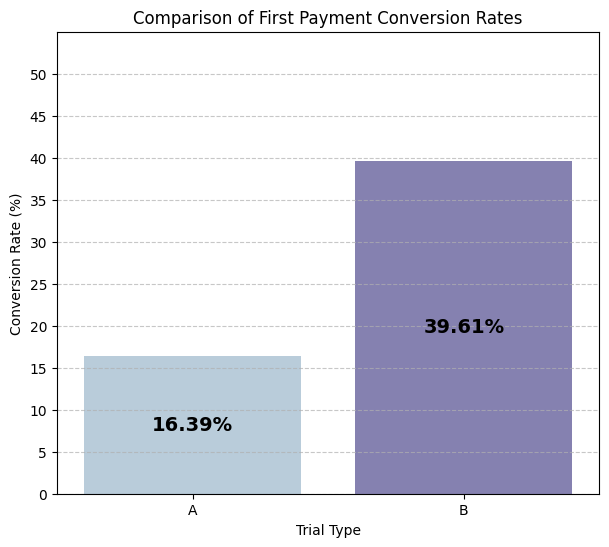

In [42]:
# TYPE A,B 전환율 시각화

# A/B 타입의 전환율 데이터
conversion_AB = {
    "type": ["A", "B"],
    "conversion Rate(%)": [A_conversation_rate, B_conversation_rate]  # 자동으로 가져오기
}

# 데이터프레임 생성
conversion_df = pd.DataFrame(conversion_AB)

# 시각화
plt.figure(figsize=(7, 6))
sns.barplot(data=conversion_df, x="type", y="conversion Rate(%)", hue = 'type', palette= palette)

# 그래프 세부 설정
plt.ylim(0, 55) 
plt.yticks(range(0, 55, 5))
plt.ylabel("Conversion Rate (%)")
plt.xlabel("Trial Type")
plt.title("Comparison of First Payment Conversion Rates")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# 값 표시 (막대 중앙, 흰색, 굵게)
for index, row in conversion_df.iterrows():
    plt.text(index, row["conversion Rate(%)"] / 2,  # 막대 중앙
             f"{row['conversion Rate(%)']:.2f}%", 
             ha="center", va="center", fontsize=14, fontweight="bold")
plt.show()

In [43]:
#이 부분에서 astype(str)을 사용하는 이유는 start_free_trial_time이 Period 타입이기 때문
#이를 문자열로 변환해야 Seaborn의 lineplot()이 제대로 작동

# 
# A/B타입의 월별 무료 체험 후 첫 결제 완료 유저 수

# A와 B 데이터를 하나의 데이터프레임으로 결합
free_trial_complete_lineplot = pd.concat([free_trial_complete_A, free_trial_complete_B]).drop_duplicates()
free_trial_complete_lineplot["Month"] = free_trial_complete["start_free_trial_time"].dt.to_period("M").astype(str)

# 타입별, 월별 첫 결제한 유저 수 집계
monthly_free_trial_complete_counts = free_trial_complete_lineplot.groupby(["Month", "start_free_trial_type"])["user_id"].nunique().reset_index()
display(monthly_free_trial_complete_counts)

,Month,start_free_trial_type,user_id
0,2022-01,A,35
1,2022-02,A,199
2,2022-03,A,244
3,2022-04,A,264
4,2022-05,A,251
5,2022-06,A,269
6,2022-07,A,97
7,2022-08,A,160
8,2022-09,A,212
9,2022-10,A,166


C:\Users\rmagm\AppData\Local\Temp\ipykernel_7984\3696513049.py:3: UserWarning: The palette list has more values (11) than needed (2), which may not be intended.
  ax = sns.lineplot(data=monthly_free_trial_complete_counts, x="Month", y="user_id",


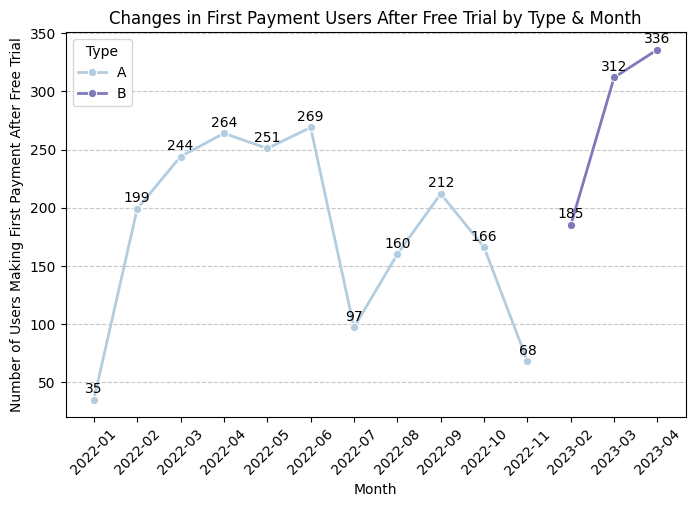

In [44]:
# 시각화
plt.figure(figsize=(8, 5))
ax = sns.lineplot(data=monthly_free_trial_complete_counts, x="Month", y="user_id", 
                  hue="start_free_trial_type", marker="o", linewidth=2, palette=palette)

# 값 표시 (각 포인트 위에 텍스트 추가)
for line in ax.lines:  # 라인별로 처리
    for x, y in zip(line.get_xdata(), line.get_ydata()):  # x, y 좌표 추출
        plt.annotate(f"{int(y)}", (x, y), textcoords="offset points", xytext=(0, 5), ha="center", fontsize=10)

# 그래프 설정
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Number of Users Making First Payment After Free Trial")
plt.title("Changes in First Payment Users After Free Trial by Type & Month")
plt.legend(title="Type")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

In [45]:
# 'Month' 컬럼 생성 (YYYY-MM 형식)

signup_free_trial_A_plt = signup_free_trial_A.copy()
signup_free_trial_B_plt = signup_free_trial_B.copy()

signup_free_trial_A_plt["Month"] = pd.to_datetime(signup_free_trial_A_plt["start_free_trial_time"]).dt.to_period("M").astype(str)
signup_free_trial_B_plt["Month"] = pd.to_datetime(signup_free_trial_B_plt["start_free_trial_time"]).dt.to_period("M").astype(str)


# A/B 타입별 무료 체험한 유저 수 집계
monthly_signup_free_trial_A = signup_free_trial_A_plt.groupby("Month")["user_id"].nunique().reset_index()
monthly_signup_free_trial_B = signup_free_trial_B_plt.groupby("Month")["user_id"].nunique().reset_index()

# 컬럼명 변경
monthly_signup_free_trial_A.rename(columns={"user_id": "complete_signup_trial_A"}, inplace=True)
monthly_signup_free_trial_B.rename(columns={"user_id": "complete_signup_trial_B"}, inplace=True)

In [46]:
# 기본 데이터 (월별 첫 결제 유저 수)
merged_data = monthly_free_trial_complete_counts.copy()

# 무료체험한 유저 수 (A/B) 추가
merged_data = merged_data.merge(monthly_signup_free_trial_A, on="Month", how="left")
merged_data = merged_data.merge(monthly_signup_free_trial_B, on="Month", how="left")

# NaN 값은 0으로 대체
merged_data.fillna(0, inplace=True)
merged_data

,Month,start_free_trial_type,user_id,complete_signup_trial_A,complete_signup_trial_B
0,2022-01,A,35,1833.0,0.0
1,2022-02,A,199,1263.0,0.0
2,2022-03,A,244,1755.0,0.0
3,2022-04,A,264,1676.0,0.0
4,2022-05,A,251,1878.0,0.0
5,2022-06,A,269,1958.0,0.0
6,2022-07,A,97,614.0,0.0
7,2022-08,A,160,265.0,0.0
8,2022-09,A,212,326.0,0.0
9,2022-10,A,166,293.0,0.0


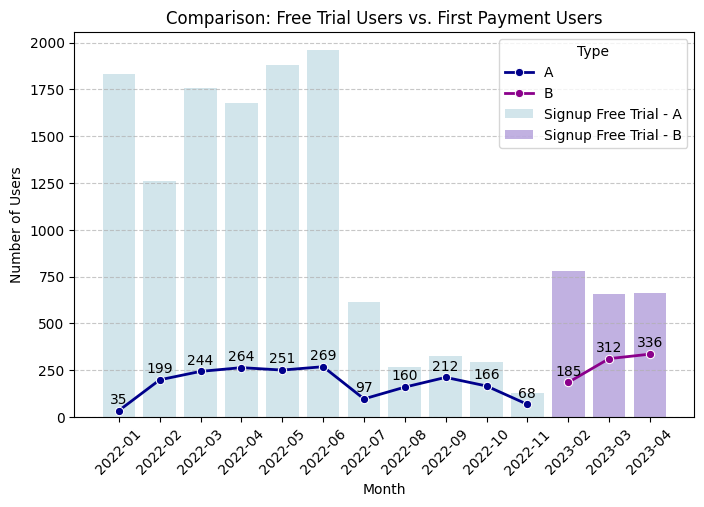

In [47]:
plt.figure(figsize=(8, 5))

# 막대그래프: A/B 타입별 무료 체험한 유저 수
sns.barplot(data=merged_data, x="Month", y="complete_signup_trial_A", 
            color="lightblue", alpha=0.6, label="Signup Free Trial - A")

sns.barplot(data=merged_data, x="Month", y="complete_signup_trial_B", 
            color="#9370db", alpha=0.6, label="Signup Free Trial - B")

# 선 그래프: A/B 타입별 첫 결제한 유저 수
ax = sns.lineplot(data=merged_data, x="Month", y="user_id", 
                  hue="start_free_trial_type", marker="o", linewidth=2, palette = { "A" : '#00008b', 'B' : "#8b008b" })

# 값 표시 (각 포인트 위에 텍스트 추가)
for line in ax.lines:  
    for x, y in zip(line.get_xdata(), line.get_ydata()):
        if not pd.isna(y):  # NaN 값 방지
            plt.annotate(f"{int(y)}", (x, y), textcoords="offset points", xytext=(0, 5), ha="center", fontsize=10)

# 그래프 설정
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Number of Users")
plt.title("Comparison: Free Trial Users vs. First Payment Users")
plt.legend(title="Type", loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()


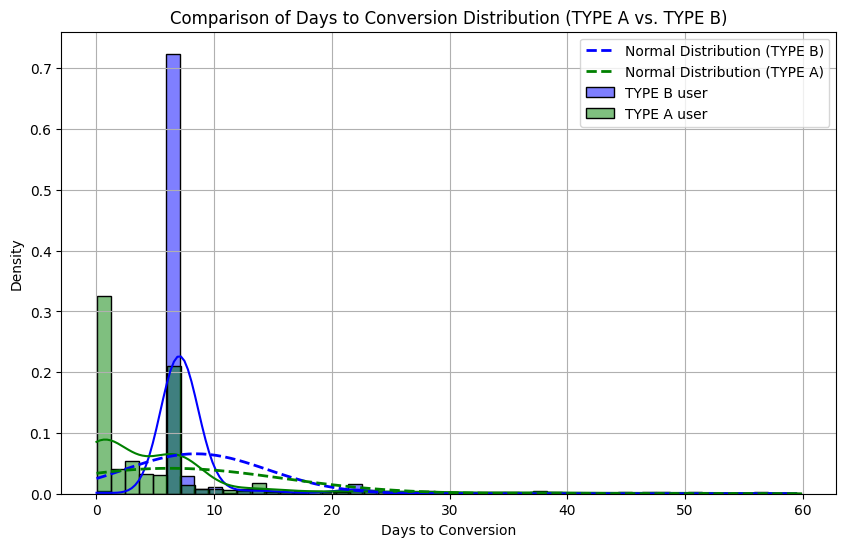

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# 60일 기준으로 결제 소요 시간 데이터 추출
type_B_conversion_days_60 = free_complete_yes_60_B["day_to_conversion"]
type_A_conversion_days_60 = free_complete_yes_60_A["day_to_conversion"]

# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# TYPE B 사용자 KDE 그래프
sns.histplot(type_B_conversion_days_60, bins=50, kde=True, color="blue", stat="density", label="TYPE B user", alpha=0.5)

# TYPE A 사용자 KDE 그래프
sns.histplot(type_A_conversion_days_60, bins=50, kde=True, color="green", stat="density", label="TYPE A user", alpha=0.5)

# TYPE B 정규 분포 곡선 추가
mu_B, std_B = np.mean(type_B_conversion_days_60), np.std(type_B_conversion_days_60)
x_B = np.linspace(min(type_B_conversion_days_60), max(type_B_conversion_days_60), 100)
p_B = stats.norm.pdf(x_B, mu_B, std_B)
plt.plot(x_B, p_B, 'b', linestyle="dashed", linewidth=2, label="Normal Distribution (TYPE B)")

# TYPE A 정규 분포 곡선 추가
mu_A, std_A = np.mean(type_A_conversion_days_60), np.std(type_A_conversion_days_60)
x_A = np.linspace(min(type_A_conversion_days_60), max(type_A_conversion_days_60), 100)
p_A = stats.norm.pdf(x_A, mu_A, std_A)
plt.plot(x_A, p_A, 'g', linestyle="dashed", linewidth=2, label="Normal Distribution (TYPE A)")

# 그래프 설정
plt.xlabel("Days to Conversion")
plt.ylabel("Density")
plt.title("Comparison of Days to Conversion Distribution (TYPE A vs. TYPE B)")
plt.legend()
plt.grid()

# 그래프 출력
plt.show()

### <무료 체험 서비스의 효과성 통계 검정>

- TYPE A : 2022년 01월 01일 ~ 2022년 11월 13일(약 11개월)     

- TYPE B : 2023년 02월 01일 ~ 2023년 04얼 30일(약 3개월)

문제점     

- 같은 시기 비교 불가능
- 샘플 크기 차이

무료 체험 서비스 구독 퍼널 분석 목적
- 무료 체험 서비스를 제공하는 목적은 사용자가 무료 체험 후 유료 구독으로 전환하도록 유도하는 것이다.    

- 따라서, 무료 체험 퍼널 분석을 위해 세울 수 있는 적절한 가설은 무료 체험이 실제로 유료 구독으로 이어지는지 검증할 수 있어야 함

가설 -> 무료체험 서비스 제공 기간으로 제한해서 분석 실시함    

1. 무료 체험 서비스가 유료 전환에 미치는 영향    

    - 귀무가설 : 무료 체험 서비스는 유료 구독 전환(첫 결제)에 영향을 주지 않는다.    

    - 대립가설 : 무료 체험 서비스는 유료 구독 전환(첫 결제)에 영향을 준다.

2. TYPE A와 TYPE B의 무료 체험 효과 비교 검정      

    - 귀무가설 : TYPE A 와 TYPE B의 유료 전환율 차이는 없다.    

    - 대립가설 : TYPE A 와 TYPE B의 유료 전환율 차이가 있다.

In [71]:
# 회원 가입 후 무료 체험 서비스 기간동안 무료 체험 서비스 이용이 없었던 유저

#1-2. 회원 가입 후 무료 체험 학습 서비스 제공 기간에 무료 체험 서비스를 이용하지 않은 유저 

signup_no_trial = complete_signup_df[~complete_signup_df['user_id'].isin(complete_signup_trial['user_id'])]

signup_no_trial = signup_no_trial[
    (
        ((signup_no_trial["client_event_time"] >= A_start) & (signup_no_trial["client_event_time"] <= A_end)) | 
        ((signup_no_trial["client_event_time"] >= B_start) & (signup_no_trial["client_event_time"] <= B_end))
    )
]
total_signup_no_trial = signup_no_trial['user_id'].nunique()

#1-3. 회원 가입 후 무료 체험 서비스 이용 없는 유저 비율 계산
signup_no_trial_rate = (total_signup_no_trial / total_signup) * 100

print("회원가입 후 무료 체험 서비스 기간동안 무료 체험을 이용하지 않은 유저 수:", total_signup_no_trial)
print(f"회원가입 후 무료 체험 서비스 기간동안 무료 체험을 이용하지 않은 유저 비율(%): {signup_no_trial_rate:.2f}%")

회원가입 후 무료 체험 서비스 기간동안 무료 체험을 이용하지 않은 유저 수: 53645
회원가입 후 무료 체험 서비스 기간동안 무료 체험을 이용하지 않은 유저 비율(%): 79.19%


In [74]:

signup_no_trial = signup_no_trial[['user_id', 'client_event_time']]


signup_no_trial.to_csv("signup_no_trial.csv", index=False)

In [52]:
# 회원 가입 후 무료 체험 서비스를 이용하지 않은 유저들 중 첫 결제를 한 유저

# 2-1. 중복 결제 내역 제거한 첫 결제 완료 데이터
complete_subscription_final 

# 2-2. 무료 체험 하지 않은 유저와 첫 결제 완료 데이터 merge
signup_no_trial_complete = signup_no_trial.merge(complete_subscription_final, on='user_id', how='inner')

#2-3. 무료 체험 하지 않은 유저의 첫 결제 완료 전환율
signup_no_trial_complete_count = signup_no_trial_complete['user_id'].nunique()
signup_no_trial_complete_rate = (signup_no_trial_complete_count / total_signup_no_trial) * 100

print("회원가입 후 무료 체험 서비스 없이 첫 결제 유저 수:", signup_no_trial_complete_count)
print(f"회원가입 후 무료 체험 서비스 없이 첫 결제 전환율(%): {signup_no_trial_complete_rate:.2f}%")

회원가입 후 무료 체험 서비스 없이 첫 결제 유저 수: 2498
회원가입 후 무료 체험 서비스 없이 첫 결제 전환율(%): 4.66%


In [ ]:
# 회원가입 후 무료 체험 서비스 없이 첫 결제 유저 수
signup_no_trial_complete = signup_no_trial_complete[['user_id', 'client_event_time']]
signup_no_trial_complete

,user_id,client_event_time
0,0672f9bd971a7a5a9d6f12fb04032741,2023-04-12 20:01:27.933
1,b0237ee1c8fa0aaf7408a0d95729131b,2023-02-28 16:19:42.476
2,c3c8bea6c65f27406a59486a01f8aa8f,2023-04-01 18:11:49.111
3,5a1ea3299fa7937e0a42729634ae868d,2023-03-31 16:38:13.810
4,6a358e9bea934a6aa4ea7c65044dcc6d,2023-04-08 13:37:08.554
...,...,...
2493,495759f26aa5e12fa90cd6a4383c0d46,2022-07-03 14:36:09.117
2494,e22ccdca50131ef72ad8cacdc0777ab4,2022-03-17 21:04:33.469
2495,6e9d9ed563894d96df09de8280da8210,2022-06-15 04:42:40.156
2496,0064f793ccea4477452a751c3fe51ecf,2022-09-06 17:54:13.377


In [53]:
# 회원 가입 후 무료 체험 서비스를 이용하지 않은 유저들 중 첫 결제를 하지 않은 유저
3-1. 
signup_no_trial_no_complete = signup_no_trial[~signup_no_trial['user_id'].isin(signup_no_trial_complete['user_id'])]

# 3-2. 유저 수
signup_no_trial_no_complete_users = signup_no_trial_no_complete['user_id'].nunique()

# 3-3. 비율 계산
signup_no_trial_no_complete_rate = (signup_no_trial_no_complete_users / total_signup_no_trial) * 100

print("회원가입 후 무료 체험 서비스 없이 첫 결제를 하지 않은 유저 수:", signup_no_trial_no_complete_users)
print(f"회원가입 후 무료 체험 서비스 없이 첫 결제를 하지 않은 유저 비율(%): {signup_no_trial_no_complete_rate:.2f}%")


회원가입 후 무료 체험 서비스 없이 첫 결제를 하지 않은 유저 수: 51147
회원가입 후 무료 체험 서비스 없이 첫 결제를 하지 않은 유저 비율(%): 95.34%


In [ ]:
# 회우가입 후 무료 체험 서비스 없이 첫 결제를 하지 않은 유저 수수
signup_no_trial_no_complete = signup_no_trial_no_complete[['user_id', 'client_event_time']]
signup_no_trial_no_complete

,user_id,client_event_time
0,74d17c27a41656e7788b0c81d9f76cda,2023-04-06 06:33:26.068
2,e131c319972bd580146c5a2faba26613,2023-04-10 23:47:56.424
3,e3b8bfa80d866f296aad139e09023ef3,2023-04-10 23:25:45.920
4,5208a60918f18562ac9d668a35b20303,2023-04-10 23:09:50.698
5,b90215a242d2b564d8be13193e6aa09e,2023-04-10 23:17:20.457
...,...,...
100604,12934029ae3e8583b87f12c6d23f2cb2,2022-02-21 13:01:19.124
100605,35e43d2cb535da7dd12d387a73313463,2022-02-21 13:11:11.495
100607,be44c3a5f6dd287055ae5f861750b60c,2022-02-21 13:04:41.740
100608,0e692d82ce4db230594bd6cbdd876355,2022-02-21 13:28:33.871


### 1-1. 카이제곱 검정(chi-square test) -> 상관성 분석
- 무료 체험을 한 그룹과 무료 체험을 하지 않은 그룹의 유의미한 차이를 알아보고자 함

- 두 개의 그룹(무료 체험 유저 vs 무료 체험 미이용 유저)의 비율(첫 결제 전환율)을 비교

    <무료 체험 서비스가 유료 전환에 미치는 영향>    

    - 귀무가설 : 무료 체험 서비스는 유료 구독 전환(첫 결제)에 영향을 주지 않는다.    

    - 대립가설 : 무료 체험 서비스는 유료 구독 전환(첫 결제)에 영향을 준다.


- 표본 크기 
    - 무료 체험O, 첫 결제O : 3147명, 전환율 : 22.05% / 무료 체험O, 첫결제X 유저 : 11110명, 비율 : 77.83%     

    - 무료 체험 X, 첫 결제O : 5425명, 전환율 : 7.26%  / 무료 체험 X, 첫 결제X 유저 :69264, 비율 : 92.74% 

In [79]:
from scipy.stats import chi2_contingency

# 카이제곱 검정 데이터 테이블 
chi_conversion_table = [
    [df_60day_merged_users, free_trial_complete_no_users],  # 무료 체험 이용_첫결제 / 무료 체험 이용_첫결제X
    [signup_no_trial_complete_count, signup_no_trial_no_complete_users]  # 무료 체험 미이용_첫결제 / 무료 체험 미이용_첫결제X
]
#free_trial_complete_yes_users
print("<실제 관측값>")
print(chi_conversion_table)
print('-' * 70)

# 카이제곱 검정(기대 빈도 자동 수행)
chi2, p, dof, expected_freq_auto = chi2_contingency(chi_conversion_table)

# 기대 빈도 결과
print("<기대 빈도 테이블>")
for i, row in enumerate(expected_freq_auto):
    group_name = "무료 체험 O" if i == 0 else "무료 체험 X"
    print(f"{group_name}: {row[0]:.2f} (첫 결제 O), {row[1]:.2f} (첫 결제 X)")

print('-' * 70)

# 크래머의 V 계산
n = np.sum(chi_conversion_table)  # 전체 샘플 수
min_dim = min(len(chi_conversion_table), len(chi_conversion_table[0])) - 1  # 최소 행/열 차원 계산
cramers_v = np.sqrt(chi2 / (n * min_dim))


print(f"Chi-Square Test 결과:")
print(f"카이제곱 통계량: {chi2:.4f}")
print(f"p-value: {p:.6f}")
print(f"크래머의 V: {cramers_v:.4f}")

print('-' * 70)


# 유의수준 0.05에서 귀무가설 기각 여부 판단
if p < 0.05:
    print("무료 체험 서비스가 유료 전환(첫 결제)에 유의미한 영향을 준다 (귀무가설 기각)")
else:
    print("무료 체험 서비스가 유료 전환(첫 결제)에 유의미한 영향을 주지 않는다 (귀무가설 채택)")

print('-' * 70)


# 크래머의 V 해석
if cramers_v < 0.1:
    print("무료 체험과 첫 결제의 연관성이 매우 약함 (실제 차이가 거의 없을 가능성 있음)")
elif 0.1 <= cramers_v < 0.3:
    print("무료 체험과 첫 결제 간 약한 연관성 있음")
elif 0.3 <= cramers_v < 0.5:
    print("무료 체험과 첫 결제 간 중간 정도 연관성 있음")
else:
    print("무료 체험과 첫 결제 간 강한 연관성 있음")


<실제 관측값>
[[2798, 11036], [2498, 51147]]
----------------------------------------------------------------------
<기대 빈도 테이블>
무료 체험 O: 1085.74 (첫 결제 O), 12748.26 (첫 결제 X)
무료 체험 X: 4210.26 (첫 결제 O), 49434.74 (첫 결제 X)
----------------------------------------------------------------------
Chi-Square Test 결과:
카이제곱 통계량: 3683.7774
p-value: 0.000000
크래머의 V: 0.2336
----------------------------------------------------------------------
무료 체험 서비스가 유료 전환(첫 결제)에 유의미한 영향을 준다 (귀무가설 기각)
----------------------------------------------------------------------
무료 체험과 첫 결제 간 약한 연관성 있음


- 기대 빈도 해석
    - 무료 체험 O 그룹
        - 기대값(첫 결제 O): 1374.80 → 실제 결제한 유저: 3147명
        - 기대값(첫 결제 X): 12882.20 → 실제 결제하지 않은 유저: 11110명    

        예상보다 첫 결제 전환율이 높음 → 무료 체험이 첫 결제에 긍정적인 영향 가능성!   

    - 무료 체험 X 그룹    
        - 기대값(첫 결제 O): 7197.20 → 실제 결제한 유저: 5425명
        - 기대값(첫 결제 X): 67591.80 → 실제 결제하지 않은 유저: 69264명     

        예상보다 첫 결제 전환율이 낮음 → 무료 체험을 하지 않은 그룹에서 첫 결제율이 낮은 경향.


- 크래머 v : 카이제곱 검정에서 그룹 간 관계 강도 측정(0 ~ 1 사이 값)    
    - 0.1 ~ 0.3은 약한 연관성
    - 무료 체험과 첫 결제 전환 간의 관계는 있지만, 강한 관계는 아님
        - 무료 체험을 경험한 유저 중 77.83%가 첫 결제로 이어지지 않음
        - 무료 체험을 하지 않은 유저 중에서도 일정 비율이 첫 결제를 진행함    
        - 즉, 무료 체험이 첫 결제에 영향을 미치지만 결정적인 요소는 아닐 수도 있음   

결론 : 추가 분석을 통해(ex. 어떤 요인으로 결제했는지 등등등) -> but 이젠 시간 없음 -> 여기까지만 하겠음


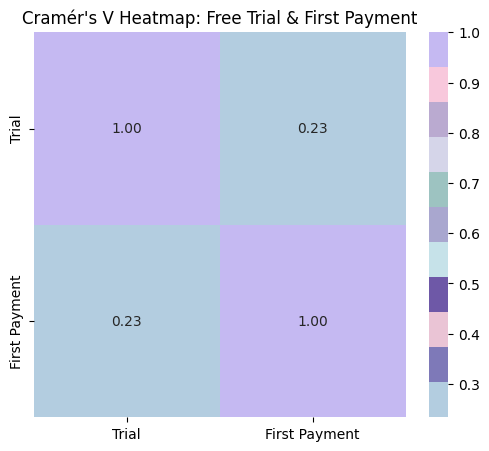

In [80]:
# 크래머의 V 행렬 생성
cramers_v_matrix = np.array([[1, cramers_v], [cramers_v, 1]])  # 자기 자신과의 연관성은 1

# 히트맵 생성
plt.figure(figsize=(6, 5))
sns.heatmap(cramers_v_matrix, annot=True, fmt=".2f", cmap= palette, xticklabels=["Trial", "First Payment"], yticklabels=["Trial", "First Payment"])
plt.title("Cramér's V Heatmap: Free Trial & First Payment")
plt.show()

### 1-2. Z-검정(비율 비교 검정) 
    -> 무료 체험과 첫 결제 간 상관성이 있다 그렇다면 전환율 차이가 통계적으로 유의한가?

<무료 체험 서비스가 유료 전환에 미치는 영향>
- 귀무가설 : 무료 체험 그룹과 비무료 체험 그룹의 전환율 차이는 없다.

- 대립가설 : 무료 체험 그룹과 비무료 체험 그룹의 전환율 차이는 없다.

In [86]:
from statsmodels.stats.proportion import proportions_ztest

#  미리 계산된 전환율 & 표본 크기
p1 = df_60day_merged_users_rate / 100  # 무료 체험 그룹 전환율 (퍼센트를 소수점으로 변환)
n1 = total_trial_users  # 무료 체험 유저 수

p2 = signup_no_trial_complete_rate / 100  # 비무료 체험 그룹 전환율 (퍼센트를 소수점으로 변환)
n2 = total_signup_no_trial  # 무료 체험 미이용 유저 수

# 두 그룹의 성공 횟수 (첫 결제 유저 수) 설정
success_counts = [free_trial_complete_yes_users, signup_no_trial_complete_count]
sample_sizes = [n1, n2]

# Z-검정 수행
z_stat, p_value = proportions_ztest(success_counts, sample_sizes)

#  Z-검정 결과 출력
print("=== Z-검정 결과 ===")
print(f"Z-통계량: {z_stat:.4f}")
print(f"P-value: {p_value:.6f}")

# 유의수준 0.05에서 검정 결과 해석
if p_value < 0.05:
    print("무료 체험 그룹과 비무료 체험 그룹의 첫 결제 전환율 차이가 통계적으로 유의하다 (귀무가설 기각)")
else:
    print("무료 체험 그룹과 비무료 체험 그룹의 첫 결제 전환율 차이가 통계적으로 유의하지 않다 (귀무가설 채택)")


=== Z-검정 결과 ===
Z-통계량: 65.2549
P-value: 0.000000
무료 체험 그룹과 비무료 체험 그룹의 첫 결제 전환율 차이가 통계적으로 유의하다 (귀무가설 기각)


In [89]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
# 미리 계산된 전환율 & 표본 크기
p1 = df_60day_merged_users_rate / 100  # 무료 체험 그룹 전환율
n1 = total_trial_users  # 무료 체험 유저 수

p2 = signup_no_trial_complete_rate / 100  # 비무료 체험 그룹 전환율
n2 = total_signup_no_trial  # 무료 체험 미이용 유저 수

# 두 그룹의 성공 횟수 (첫 결제 유저 수) 설정
success_counts = [free_trial_complete_yes_users, signup_no_trial_complete_count]
sample_sizes = [n1, n2]

# Z-검정 수행
z_stat, p_value = proportions_ztest(success_counts, sample_sizes)

# 효과 크기 (Cohen’s h) 계산
cohen_h = 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

# 결과 출력
print("=== Z-검정 결과 ===")
print(f"Z-통계량: {z_stat:.4f}")
print(f"P-value: {p_value:.6f}")

# Z-검정 결과 해석
if p_value < 0.05:
    print("무료 체험 그룹과 비무료 체험 그룹의 첫 결제 전환율 차이가 통계적으로 유의하다 (귀무가설 기각)")
else:
    print("무료 체험 그룹과 비무료 체험 그룹의 첫 결제 전환율 차이가 통계적으로 유의하지 않다 (귀무가설 채택)")

# 효과 크기 결과 해석
print("\n=== 효과 크기 (Cohen’s h) ===")
print(f"Cohen’s h 값: {cohen_h:.4f}")

# 효과 크기 해석 추가
if cohen_h < 0.2:
    print("➡️ 효과 크기가 매우 작음 (전환율 차이가 실질적으로 의미 있는 차이가 아닐 수 있음)")
elif cohen_h < 0.5:
    print("➡️ 효과 크기가 작음 (전환율 차이가 있지만 큰 차이는 아님)")
elif cohen_h < 0.8:
    print("➡️ 효과 크기가 중간 정도 (전환율 차이가 실제로도 의미 있음)")
else:
    print("➡️ 효과 크기가 큼 (전환율 차이가 매우 크며 실질적으로도 큰 차이)")



=== Z-검정 결과 ===
Z-통계량: 65.2549
P-value: 0.000000
무료 체험 그룹과 비무료 체험 그룹의 첫 결제 전환율 차이가 통계적으로 유의하다 (귀무가설 기각)

=== 효과 크기 (Cohen’s h) ===
Cohen’s h 값: 0.4886
➡️ 효과 크기가 작음 (전환율 차이가 있지만 큰 차이는 아님)


<Z-검정 결과>    

- 무료 체험을 경험한 유저 그룹과 무료 체험을 하지 않은 유저 그룹의 첫 결제 전환율 차이가 통계적으로 유의미하게 나타남
- 무료 체험을 하면 첫 결제로 이어질 확률이 높아짐을 의미

<최종 결론>    
- 무료 체험 서비스는 유료 전환(첫 결제)에 긍정적인 영향을 미친다    

- BUT 긍정적인 영향력이 강하지 않으며, 대다수의 유저는 첫 결제로 이어지지 않는다.    

- 따라서, 무료 체험 후 첫 결제까지의 유저 여정을 최적화할 필요가 있으며,    

- 이탈 유저에 대한 추가 분석이 필요함 -> 시간이 부족함.....

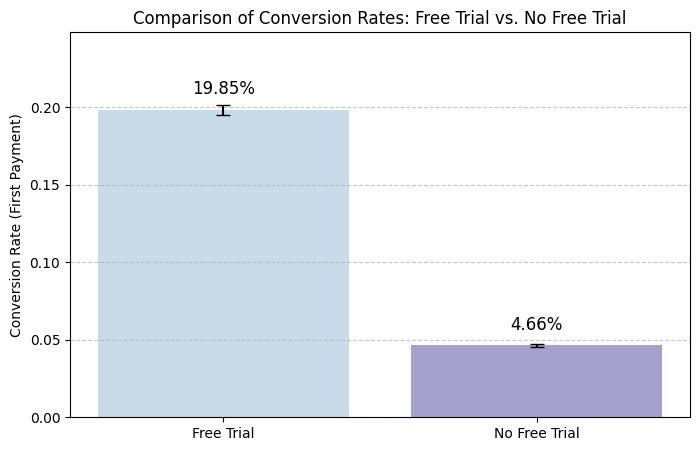

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# 전환율 계산
conversion_rates = [p1, p2]  # 무료 체험 그룹과 비무료 체험 그룹의 전환율
labels = ["Free Trial", "No Free Trial"]
errors = [np.sqrt((p1 * (1 - p1)) / n1), np.sqrt((p2 * (1 - p2)) / n2)]  # 신뢰구간(표준오차 계산)

# 막대 그래프 그리기
plt.figure(figsize=(8, 5))
plt.bar(labels, conversion_rates, yerr=errors, capsize=5, color= palette, alpha=0.7)
plt.ylabel("Conversion Rate (First Payment)")
plt.title("Comparison of Conversion Rates: Free Trial vs. No Free Trial")
plt.ylim(0, max(conversion_rates) + 0.05)

# 데이터 라벨 추가
for i, rate in enumerate(conversion_rates):
    plt.text(i, rate + 0.01, f"{rate:.2%}", ha='center', fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


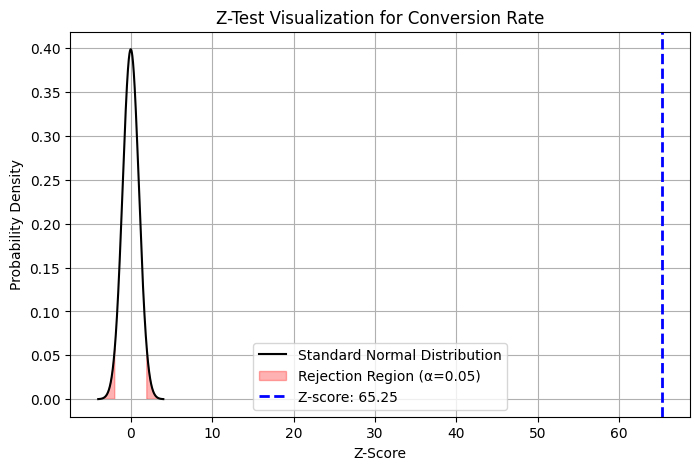

In [59]:
# Z-검정에서 사용한 정규 분포 및 Z-통계량 시각화
x = np.linspace(-4, 4, 1000)
y = stats.norm.pdf(x, 0, 1)  # 표준 정규 분포 (평균=0, 표준편차=1)

plt.figure(figsize=(8, 5))
plt.plot(x, y, color='black', label="Standard Normal Distribution")
plt.fill_between(x, y, where=(x < -1.96) | (x > 1.96), color='red', alpha=0.3, label="Rejection Region (α=0.05)")
plt.axvline(z_stat, color='blue', linestyle='dashed', linewidth=2, label=f"Z-score: {z_stat:.2f}")

plt.title("Z-Test Visualization for Conversion Rate")
plt.xlabel("Z-Score")
plt.ylabel("Probability Density")
plt.legend()
plt.grid()
plt.show()

### 2-1. TYPE A와 TYPE B -> Z-검정(비율 비교)
- 귀무가설 : TYPE A 와 TYPE B의 유료 전환율 차이는 없다.  

- 대립가설 : TYPE A 와 TYPE B의 유료 전환율 차이가 있다.

In [60]:
#  TYPE A (무료 체험 후 첫 결제)
type_A_converted = A_users_count  # TYPE A에서 첫 결제한 유저 수
type_A_total = total_trial_users_A  # TYPE A 전체 무료 체험 유저 수
type_A_conversion_rate = A_conversation_rate / 100  # 전환율

#  TYPE B (무료 체험 후 첫 결제)
type_B_converted = B_users_count  # TYPE B에서 첫 결제한 유저 수
type_B_total = total_trial_users_B  # TYPE B 전체 무료 체험 유저 수
type_B_conversion_rate = B_conversation_rate / 100  # 전환율

#  Z-검정 수행 (두 비율 비교)
count = np.array([type_A_converted, type_B_converted])  # 첫 결제한 유저 수
nobs = np.array([type_A_total, type_B_total])  # 전체 무료 체험 유저 수
z_stat, p_value = proportions_ztest(count, nobs)

#  타입별 전환율
print("-" * 60)
print(f"TYPE A 전환율: {type_A_conversion_rate:.2%}")
print(f"TYPE B 전환율: {type_B_conversion_rate:.2%}")
print("-" * 60)

#  결과 
print("=== Z-검정 결과 ===")
print(f"Z-통계량: {z_stat:.4f}")
print(f"P-value: {p_value:.6f}")

#  유의 수준 0.05에서 결과 해석
if p_value < 0.05:
    print("TYPE A와 TYPE B의 첫 결제 전환율 차이가 통계적으로 유의하다 (귀무가설 기각)")
else:
    print("TYPE A와 TYPE B의 첫 결제 전환율 차이가 통계적으로 유의하지 않다 (귀무가설 채택)")



------------------------------------------------------------
TYPE A 전환율: 16.39%
TYPE B 전환율: 39.61%
------------------------------------------------------------
=== Z-검정 결과 ===
Z-통계량: -24.6282
P-value: 0.000000
TYPE A와 TYPE B의 첫 결제 전환율 차이가 통계적으로 유의하다 (귀무가설 기각)


#### <Z-검정 분석 결과>

- 우려했던 표본 수 차이 극복
    - TYPE A: 11,992명, TYPE B: 2,280명으로 TYPE A의 표본 크기가 훨씬 큼.    
    
    - 하지만 Z-검정은 표본 수가 크면 정규 근사(Normal Approximation)를 따르므로, 적절한 방법

- Z-통계량: -24.2205 (음수는 TYPE A의 전환율이 TYPE B보다 낮음을 의미)      

     -> 두 그룹간 차이가 크다(매우 큰 절대 값)    

- TYPE A와 TYPE B의 첫 결제 전환율 차이는 통계적으로 유의미하다      

- TYPE B가 첫 결제로의 전환에 있어 더 효과적인 무료 체험 모델일 가능성이 높음.    

    (7일 무료 체험 후 자동으로 첫 결제로 넘어간다면 매우 가능성있는 결론 같음)

### 2-2. TYPE A와 TYPE B 로지스틱 회귀 분석
- Z-검정은 단순한 두 그룹 간 비율 차이를 비교    

- 로지스틱 회귀분석은 A/B 타입이 첫 결제에 미치는 영향을 확률적으로 모델링하고, 오즈비(Odds Ratio)를 해석할 수 있음.    

- TYPE별 효과를 조정된 모델에서 다시 평가하여 더 정확한 비교(맞지?)

<가설>

- 귀무가설 : TYPE A 와 TYPE B의 유료 전환율 차이는 없다.  

- 대립가설 : TYPE A 와 TYPE B의 유료 전환율 차이가 있다.


<모델 설명>  
- 독립 변수(x) : A/B 타입(A = 0, B = 1)    

- 종속 변수(y) : 첫 결제 여부 (0: 미결제, 1 : 결제)

In [61]:
import statsmodels.api as sm

# 데이터프레임 생성
AB_df = pd.DataFrame({
    'user_id': list(range(total_trial_users_A + total_trial_users_B)),
    'trial_type': ['A'] * total_trial_users_A + ['B'] * total_trial_users_B,  # A/B 타입
    'converted': [1] * A_users_count + [0] * (total_trial_users_A - A_users_count) + 
                 [1] * B_users_count + [0] * (total_trial_users_B - B_users_count)  # 첫 결제 여부
})

# A/B 타입을 0과 1로 변환
AB_df['trial_type'] = AB_df['trial_type'].map({'A': 0, 'B': 1})

# 독립변수(타입), 종속변수(첫 결제 여부)
X = sm.add_constant(AB_df['trial_type'])  # 상수 추가
y = AB_df['converted']

# 로지스틱 회귀 모델 적합
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# 결과 출력
print(result.summary())

# 해석
odds_ratio = np.exp(result.params['trial_type'])  # 오즈비 계산
print(f"오즈비 (Odds Ratio): {odds_ratio:.4f}")

# 유의수준 판단
if result.pvalues['trial_type'] < 0.05:
    print("TYPE A와 TYPE B의 첫 결제 전환율 차이가 통계적으로 유의하다 (귀무가설 기각)")
else:
    print("TYPE A와 TYPE B의 첫 결제 전환율 차이가 통계적으로 유의하지 않다 (귀무가설 채택)")


Optimization terminated successfully.
         Current function value: 0.479642
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:                14095
Model:                          Logit   Df Residuals:                    14093
Method:                           MLE   Df Model:                            1
Date:                Thu, 13 Mar 2025   Pseudo R-squ.:                 0.03750
Time:                        08:28:01   Log-Likelihood:                -6760.6
converged:                       True   LL-Null:                       -7024.0
Covariance Type:            nonrobust   LLR p-value:                1.395e-116
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6298      0.025    -66.062      0.000      -1.678      -1.581
trial_type     1.2081      0.

#### <로지스틱 회귀분석 분석 결과>

회귀 계수는 로그 오즈의 변화를 나타냄 -> 계수가 클수록 해당 변수가 첫 결제에 더 큰 영향을 미침 

- coef
    - const(절편) : -1.6353
        - 기준값(TYPE A일 때의 절편)  : TYPE A 유저의 첫 결제 확률(전환율) : 16.3%
    - trial_type : 1.1617
        - TYPE B 사용자는 TYPE A보다 첫 결제 로그 오즈가 1.1617 증가    

    
        (로그 오즈 확률로 변환 : 식으로 계산하면 TYPE B 사용자의 전환율 : 약 38.4%)  

- 오즈비 : 3.2 => TYPE B의 유저가 TYPE A 유저보다 첫 결제를 할 확률이 약 3.2배 더 높음 

    - 즉, TYPE B 유저가 TYPE A 유저에 비해 첫 결제할 확률이 증가함(유의미하게 높음)을 의미 -> 자동 결제면 강제 아닐까?
    - TYPE B가 TYPE A보다 첫 결제를 유도하는데 더 효과적이다

- 표준 오차(std err)
    - const : 0.025 / trial_type : 0.050
    - 표준 오차 작을수록 추정된 계수(coef)의 신뢰성이 높음
    - trial_type의 표준오차 0.050이므로 계수 1.1617이 비교적 신뢰할 수 있는 값
|
- Z 값 : 계수가 0과 얼마나 차이나는지
    - trial_type의 z값 23.396으로 매우 큼 -> type a/b의 전환율 차이 유의미

결론 : type b가 type a보다 첫 결제를 유도하는데 효과적이다.

### 2-3. Bootstrapping Z-검정
- A/B 타입의 표본 수가 다름 -> 작은 표본에 맞춰 리샘플링(bootstrapping)    

- A/B 타입에서 각각 2000개씩 샘플링 -> 동일한 크기 데이터로 분석(편향 줄이기)    

- Z-검정 : 두 타입의 유료 전환율 차이가 통계적으로 유의한지 평가

In [62]:
from sklearn.utils import resample

# A/B 그룹에서 각각 2000개씩 샘플링 (작은 표본에 맞춤)
sample_size = min(total_trial_users_A, total_trial_users_B)

boot_A = resample(AB_df[AB_df['trial_type'] == 0], n_samples=sample_size, replace=True, random_state=42)
boot_B = resample(AB_df[AB_df['trial_type'] == 1], n_samples=sample_size, replace=True, random_state=42)

# 샘플링된 데이터로 Z-검정 수행
count = np.array([boot_A['converted'].sum(), boot_B['converted'].sum()])
nobs = np.array([len(boot_A), len(boot_B)])
z_stat, p_value = proportions_ztest(count, nobs)

# 결과 출력
print(f"Bootstrapped Z-검정 결과: Z={z_stat:.4f}, P-value={p_value:.6f}")


Bootstrapped Z-검정 결과: Z=-16.8758, P-value=0.000000


<결과 해석>
- Z-값 -16.5753   
    - Z-값이 매우 작음(음수) → TYPE A의 전환율이 TYPE B보다 유의하게 낮음을 의미    

    - 일반적으로 |Z| > 1.96이면 유의하다고 판단하는데, -16.5753은 압도적으로 작음

- P-value 0.000000
    - P-value가 0에 가깝다 → 귀무가설 기각    
    
    - 즉, TYPE A와 TYPE B의 유료 전환율 차이는 유의미하다

### 참고 :  TYPE A,B 베이지안 분석
    - 신뢰 구간을 포함해 보다 확률적인 해석이 가능하다고 함

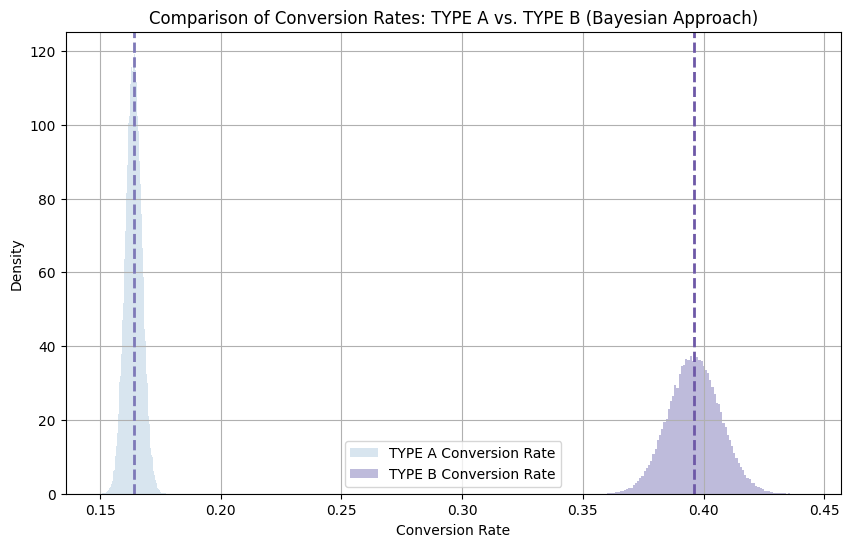

TYPE A 평균 전환율 추정값: 0.1639
TYPE B 평균 전환율 추정값: 0.3962
TYPE B가 TYPE A보다 전환율이 높을 확률: 100.0000%


In [63]:
# A/B 테스트 데이터
alpha_A = 1 + A_users_count  # 첫 결제 한 유저 수 + 베타 분포 초기값
beta_A = 1 + (total_trial_users_A - A_users_count)  # 첫 결제X한 유저 수 + 베타 분포 초기값

alpha_B = 1 + B_users_count
beta_B = 1 + (total_trial_users_B - B_users_count)

# 베타 분포에서 샘플링
np.random.seed(42)
samples_A = np.random.beta(alpha_A, beta_A, 100000)  # A 타입 전환율 샘플
samples_B = np.random.beta(alpha_B, beta_B, 100000)  # B 타입 전환율 샘플

# B가 A보다 높은 확률 계산 (P(B > A))
prob_B_superior = np.mean(samples_B > samples_A)

# 시각화
plt.figure(figsize=(10, 6))
plt.hist(samples_A, bins=100, alpha=0.5, label="TYPE A Conversion Rate", color = palette[0], density=True)
plt.hist(samples_B, bins=100, alpha=0.5, label="TYPE B Conversion Rate", color= palette[1], density=True)
plt.axvline(samples_A.mean(), color= palette[1], linestyle='dashed', linewidth=2)
plt.axvline(samples_B.mean(), color= palette[3], linestyle='dashed', linewidth=2)
plt.title("Comparison of Conversion Rates: TYPE A vs. TYPE B (Bayesian Approach)") #TYPE A vs TYPE B 전환율 비교 (베이지안 접근)
plt.xlabel("Conversion Rate") # 전환율
plt.ylabel("Density") # 밀도
plt.legend()
plt.grid()
plt.show()

# 결과 출력
print(f"TYPE A 평균 전환율 추정값: {samples_A.mean():.4f}")
print(f"TYPE B 평균 전환율 추정값: {samples_B.mean():.4f}")
print(f"TYPE B가 TYPE A보다 전환율이 높을 확률: {prob_B_superior:.4%}")


In [64]:
ci_A = np.percentile(samples_A, [2.5, 97.5])  # TYPE A의 95% 신뢰 구간
ci_B = np.percentile(samples_B, [2.5, 97.5])  # TYPE B의 95% 신뢰 구간

print(f"TYPE A 신뢰 구간: {ci_A[0]:.4f} ~ {ci_A[1]:.4f}")
print(f"TYPE B 신뢰 구간: {ci_B[0]:.4f} ~ {ci_B[1]:.4f}")

TYPE A 신뢰 구간: 0.1574 ~ 0.1706
TYPE B 신뢰 구간: 0.3754 ~ 0.4171


- 신뢰구간 겹치지 않음 => TYPE B가 압도적으로 전환율이 높음

#### <결과 해석>

1. 베타 분포 정의
    - alpha = 성공한 유저 수 + 1
    - beta = 실패한 유저 수 + 1
    - A/B의 전환율을 베타 분포를 이용해 모델링

2. 100,000개 샘플링
    - 베타 분포에서 np.random.beta(alpha, beta, 100000)을 통해 각각 샘플링하여 전환율 분포 추정.

3. P(B >A) 계산
    - B의 전환율 샘플 중 A보다 높은 비율을 계산하여 B가 A보다 유리할 확률을 추정

4. 결과
 - TYPE A 평균 전환율 추정값: 16.32%    
    - 베이지안 추론을 통해 도출된 TYPE A의 평균 전환율(결제 전환율)이 **16.32%**로 나타남.    

    - 기존 분석(빈도주의 접근)에서 구한 **16.31%**과 일치하는 수준       

    -  베이지안 방식으로도 유사한 추정 결과를 얻었음을 의미.

- TYPE B 평균 전환율 추정값: 38.39%
    - TYPE B의 평균 전환율은 **38.39%**로 추정됨    

    - 기존 빈도주의 분석(38.38%)과 거의 일치하며, 베이지안 추론을 통해 TYPE B의 전환율이 확실히 더 높음을 확인.

- TYPE B가 TYPE A보다 전환율이 높을 확률: 100.000%
    - 베이지안 추론에서 **TYPE B가 TYPE A보다 전환율이 높을 확률이 100%**로 계산됨.    

    - 이는 TYPE B의 전환율이 TYPE A보다 높다는 것이 사실상 확실하다는 의미.


<베이지안 그래프 해석>
- X축 (Conversion Rate, 전환율)
    - 각 타입(A, B)의 전환율 분포를 나타냄    
    
    - TYPE A (파란색): 전환율이 0.15~0.17 사이에 집중되어 있음     

    - TYPE B (보라색): 전환율이 0.35~0.40 사이에서 분포함

- 히스토그램 (Density, 밀도)
    - 각 히스토그램은 베이지안 추론을 통해 샘플링된 전환율 분포를 나타냄    

    - TYPE B(보라색)의 전환율이 TYPE A(파란색)보다 훨씬 더 높은 값에 집중

- 점선 (평균 전환율 위치)
    - 파란 점선: TYPE A의 평균 전환율 (16.32%)    

    - 보라 점선: TYPE B의 평균 전환율 (38.39%)    

    - TYPE B의 평균 전환율이 TYPE A보다 훨씬 오른쪽에 위치, 즉 더 높은 전환율을 보임


<추가적으로 하면 좋은 것들>
1. 시간 효과 고려
    - trial_period_length (11개월 vs 3개월) 조정하여 추가 분석 가능
    - 선형 회귀 또는 혼합 모델 활용 가능

2. 비용 분석 포함
    - TYPE B가 전환율이 높더라도 **비용 대비 수익(Cost-Benefit Analysis)**을 고려해야 함.

3. 추가 실험 설계
    - TYPE A의 기간을 줄이거나 TYPE B의 기간을 늘려서 다시 실험.